# Przetwarzanie danych

In [1]:
from sklearn.preprocessing import StandardScaler
from skfuzzy.cluster import cmeans, cmeans_predict
from sklearn.metrics import pairwise_distances_argmin_min
from sktime.datasets import load_basic_motions, load_arrow_head
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import arff

### Parametry startowe programu

In [2]:
chunk_length_train = 200
chunk_length_test = 100
std_div = 30
n_clusters = 4
dim = 6
injection = 1.0
injection_power = 0.8
m = 2.0
g_error = 0.05

### Dane

In [3]:
%cd ..

C:\Users\kubak\Desktop\github\FuzzyClusteringAlgorithms


C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### Pobieranie danych z biblioteki sktime

In [4]:
# load an example time series panel in numpy mtype Numpy 2D
X_train, y_train = load_basic_motions(split="train", return_type="numpy2D")
X_test, y_test =  load_basic_motions(split="test", return_type="numpy2D")

In [5]:
# load an example time series panel in numpy mtype Numpy 3D
X_train, y_train = load_basic_motions(split="train", return_type="numpy3D")
X_test, y_test =  load_basic_motions(split="test", return_type="numpy3D")

### Importowanie danych z dysku

In [6]:
from libraries.load import load_dataset_to_dataframe

filepath_train = './datasets/BasicMotions/BasicMotions_TRAIN.arff'
filepath_test = './datasets/BasicMotions/BasicMotions_TEST.arff'

df_train = load_dataset_to_dataframe(filepath_train)
df_test = load_dataset_to_dataframe(filepath_test)

In [7]:
from libraries.segmentation import stack_time_series, stack_time_series_randomly

stacked_train, _ , y_train = stack_time_series_randomly(df_train)
stacked_test, _ , y_test = stack_time_series_randomly(df_test)
#stacked_train, y_train = stack_time_series(df_train)
#stacked_test, y_test = stack_time_series(df_test)

C:\Users\kubak\Desktop\github\FuzzyClusteringAlgorithms\libraries\segmentation.py:66: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels.append(row[1])
C:\Users\kubak\Desktop\github\FuzzyClusteringAlgorithms\libraries\segmentation.py:67: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if last_class != row[1]:
C:\Users\kubak\Desktop\github\FuzzyClusteringAlgorithms\libraries\segmentation.py:69: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[p

In [8]:
def stack_columns(stacked_train):
    result = stacked_train.loc[0,0]
    
    for i in range(1,stacked_train.shape[0]):
        result = np.column_stack((result, stacked_train.loc[i,0]))
    return result
    
X_train = stack_columns(stacked_train)
X_test = stack_columns(stacked_test)

In [9]:
def extend_list(lista, n):
    wynik = []
    for element in lista:
        wynik.extend([element] * n)
    return wynik

y_test_extended = extend_list(y_test, 100)
y_train_extended = extend_list(y_train, 100)

In [10]:
def map_strings_to_ints(strings):
    # Utwórz słownik do mapowania stringów na inty
    string_to_int = {}
    current_int = 0
    
    # Wynikowa lista z intami
    result = []
    
    # Przejdź przez listę stringów
    for string in strings:
        # Jeśli string nie jest jeszcze w słowniku, dodaj go
        if string not in string_to_int:
            string_to_int[string] = current_int
            current_int += 1
        # Dodaj odpowiadający int do wynikowej listy
        result.append(string_to_int[string])
    
    return result

y_train = map_strings_to_ints(y_train_extended)
y_test = map_strings_to_ints(y_test_extended)

## Genrowanie syntetycznych danych

### Generowanie danych syntetycznych sinusoidalnych

In [11]:
from libraries.generate_datasets import generate_multidimensional_sine_data, generate_dataset_blobs

# Parametry
num_dimensions = 6  # liczba wymiarów 
frequency = 1  # częstotliwość
amplitude = 1  # amplituda
phase = [0, np.pi/4, np.pi/2, 0, 0, 0]  # fazy początkowe dla każdego wymiaru
duration = 50  # czas trwania sygnału
sampling_rate = 100  # liczba próbek na jednostkę czasu
noise_std = 0.2  # odchylenie standardowe szumu
num_classes = n_clusters

In [12]:
# Generowanie danych
#t_train, X_train, y_train_extended_list = generate_multidimensional_sine_data(num_dimensions, frequency, amplitude, phase, duration, sampling_rate, noise_std, num_classes)
#t_test, X_test, y_test_extended = generate_multidimensional_sine_data(num_dimensions, frequency, amplitude, phase, duration, sampling_rate, noise_std, num_classes)

### Generowanie plam

In [13]:
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA

#X_train, y_train_extended_list, X_test, y_test_extended = generate_dataset_blobs(n=3000,c=dim,k=n_clusters,seed=42)

### Generowanie prostych

In [14]:
from libraries.generate_datasets import generate_dataset_lines

# Parametry linii prostych
a_values = [2, 2, 2]  # Współczynniki a dla różnych składowych
b_values = [1, 10, 20]      # Współczynniki b dla różnych składowych
num_points = 5000           # Liczba punktów danych
std_dev = 0.1     # Odchylenie standardowe dla szumu

In [15]:
#X_train, y_train_extended_list, X_test, y_test_extended = generate_dataset_lines(a_values, b_values, num_points = num_points, std_dev = std_dev, n_clusters = n_clusters)

## Processing danych

### Tasowanie danych

In [16]:
# Zwykłe tasowanie punktów.
def shuffle_data(X, y):
    
    # Sprawdzenie czy liczba wierszy w X odpowiada liczbie elementów w y
    assert X.shape[0] == len(y), "Liczba wierszy w X musi odpowiadać liczbie elementów w y"
    
    # Losowanie indeksów
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    # Przemieszanie X i y zgodnie z wylosowanymi indeksami
    X_shuffled = X[indices]
    y_shuffled = np.array(y)[indices].tolist()
    
    return X_shuffled, y_shuffled

def sort_by_class(X, y):
    # Sortowanie według etykiet w y
    sorted_indices = np.argsort(y)
    
    # Zastosowanie posortowanych indeksów do X i y
    X_sorted = X[sorted_indices]
    y_sorted = y[sorted_indices]
    
    return X_sorted, y_sorted

# Dzieli dane dla każdej klasy na odcinki średniej długości mean  z odchyleniem standardowym std_var. Następnie tasuje tak stworzone segmenty.
def shuffle_dataset_with_chunk_sizes(X, y, mean, std_var):
    # Liczba klas
    num_classes = np.unique(y).size
    y = np.array(y)
    # Listy do przechowywania chunków i etykiet
    X_chunks = []
    y_chunks = []
    chunk_sizes_list = []

    # Ustalanie rozmiaru chunków i mieszanie w obrębie każdej klasy
    start = 0
    for i in range(num_classes):
        # Wyodrębnij dane dla danej klasy
        class_indices = np.where(y == i)[0]
        class_size = len(class_indices)
        
        # Losowanie chunków
        chunk_sizes = []
        while sum(chunk_sizes) < class_size:
            chunk_size = int(np.abs(np.random.normal(mean, std_var)))
            if sum(chunk_sizes) + chunk_size > class_size:
                chunk_size = class_size - sum(chunk_sizes)
            chunk_sizes.append(chunk_size)
        
        # Dzielenie i mieszanie chunków
        class_X_chunks = np.array_split(X[class_indices], np.cumsum(chunk_sizes[:-1]))
        class_y_chunks = np.array_split(y[class_indices], np.cumsum(chunk_sizes[:-1]))
        
        X_chunks.extend(class_X_chunks)
        y_chunks.extend(class_y_chunks)
        chunk_sizes_list.extend(chunk_sizes)

    # Mieszanie w skali całego datasetu
    combined = list(zip(X_chunks, y_chunks, chunk_sizes_list))
    np.random.shuffle(combined)
    
    # Rozdzielenie pomieszanych chunków
    X_shuffled, y_shuffled, shuffled_chunk_sizes = zip(*combined)
    
    # Spłaszczenie listy chunków
    X_shuffled = np.concatenate(X_shuffled)
    y_shuffled = np.concatenate(y_shuffled)

    return X_shuffled, y_shuffled, list(shuffled_chunk_sizes)

X_train, y_train, chunk_train_sizes = shuffle_dataset_with_chunk_sizes(X_train, y_train, chunk_length_train, std_div)
X_test, y_test, chunk_test_sizes = shuffle_dataset_with_chunk_sizes(X_test, y_test, chunk_length_test, std_div)

### Wizualizacja danych

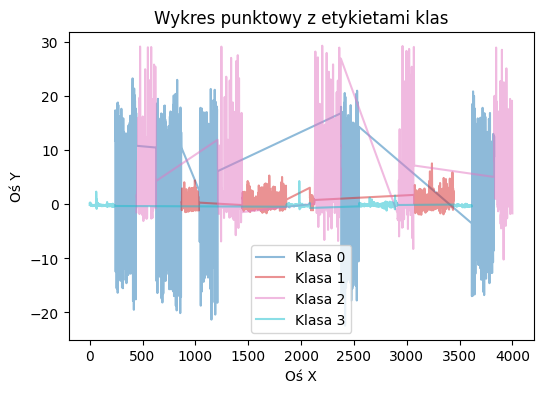

In [17]:
def show_labels_of_dataset(X, y):
  # Ustalamy unikalne etykiety
    unique_labels = np.unique(y)
    
    # Wybieramy kolory dla każdej klasy
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
    
    # Tworzenie wykresu punktowego
    plt.figure(figsize=(6, 4))
    
    for i, label in enumerate(unique_labels):
        # Wybieranie punktów dla danej klasy
        ix = np.array(np.where(label == y)).reshape(-1)
        mask = (y == label)
        plt.plot(ix, X[mask, 0], color=colors[i], label=f'Klasa {label}', alpha=0.5)
    
    # Dodanie tytułu i etykiet osi
    plt.title('Wykres punktowy z etykietami klas')
    plt.xlabel('Oś X')
    plt.ylabel('Oś Y')
    
    # Dodanie legendy
    plt.legend()
    
    # Wyświetlenie wykresu
    plt.show()

show_labels_of_dataset(X_train, y_train)

In [18]:
# Visualise Loaded Data
def visualise_loaded_data(data):
    # Create a 2x3 grid of subplots
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    # Plot different data on each subplot
    axs[0, 0].plot(data[:,0])
    axs[0, 0].set_title('accelerometer X')

    axs[0, 1].plot(data[:,1])
    axs[0, 1].set_title('accelerometer Y')

    axs[0, 2].plot(data[:,2])
    axs[0, 2].set_title('accelerometer Z')

    axs[1, 0].plot(data[:,3])
    axs[1, 0].set_title('gyroscope X')

    axs[1, 1].plot(data[:,4])
    axs[1, 1].set_title('gyroscope Y')

    axs[1, 2].plot(data[:,5])
    axs[1, 2].set_title('gyroscope Z')

    # Adjust the layout
    plt.tight_layout()

    # Show the plots
    plt.show()

# Visualise Loaded Data
def visualise_loaded_data(data):
    # Create a 2x3 grid of subplots
    c = data.shape[1]
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    for i in range(c):
        # Plot different data on each subplot
        axs[int(i/3), i%3].plot(data[:,i])
        axs[int(i/3), i%3].set_title(f'param {i}')
        
    # Adjust the layout
    plt.tight_layout()

    # Show the plots
    plt.show()

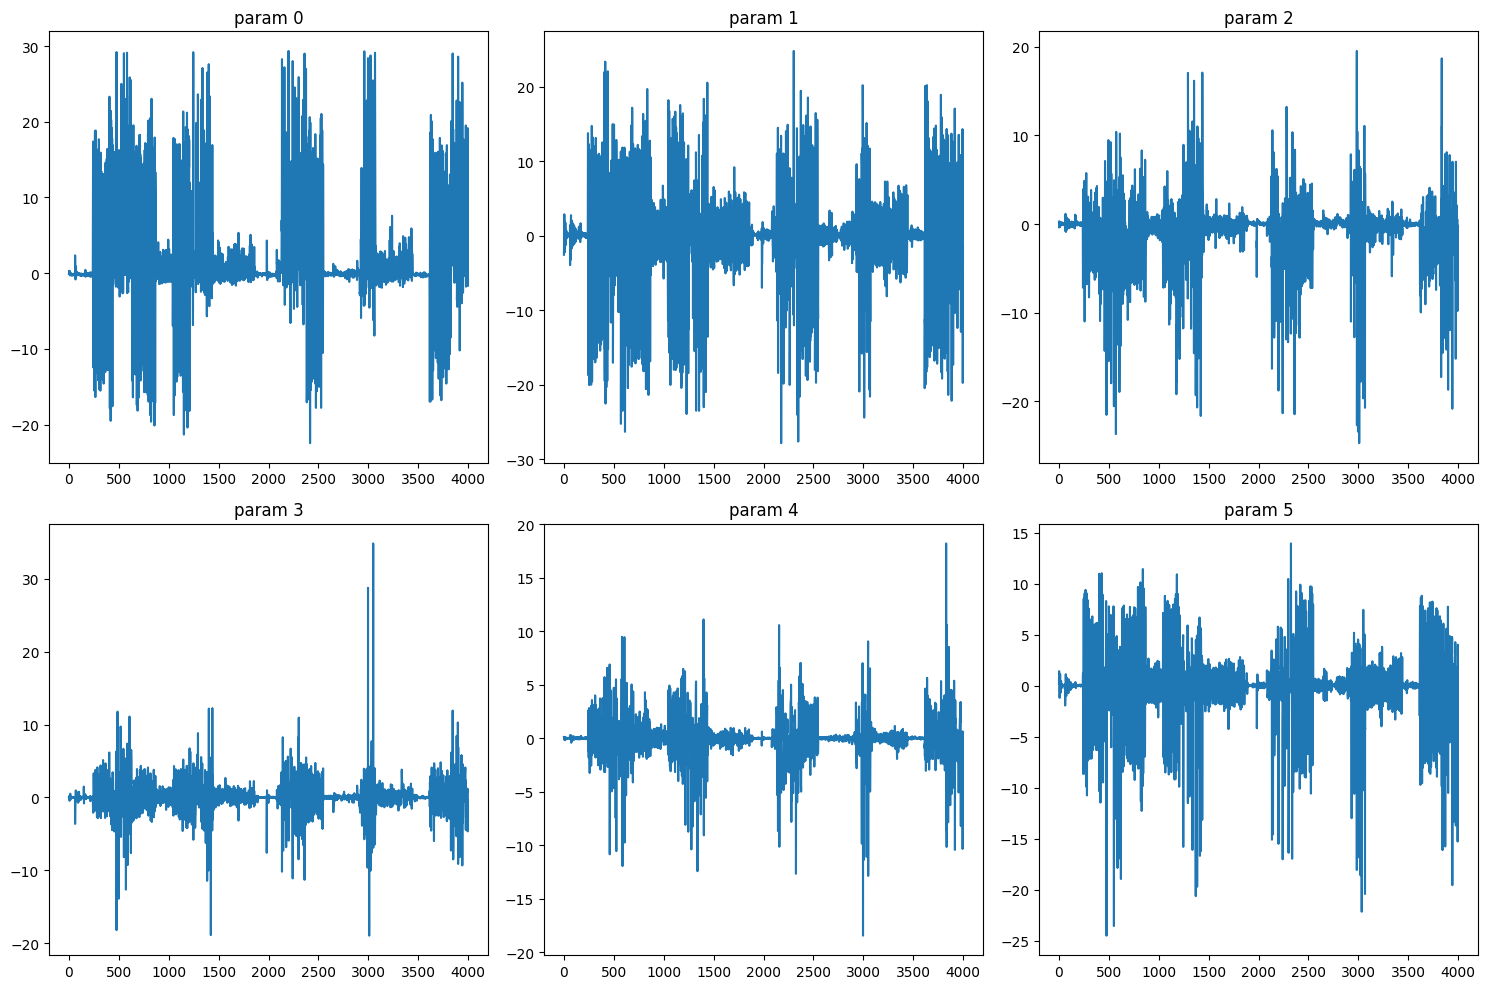

In [19]:
visualise_loaded_data(X_train)

### Punkty inicjalizacyjne i macierze semi_supervised

In [20]:
# Dla każdej klasy znajdź punkt średni.
def average_by_class(X, y):
    # Unikalne klasy w y
    classes = np.unique(y)
    
    # Słownik do przechowywania średnich dla każdej klasy
    class_averages = {}
    
    for cls in classes:
        # Wybieramy indeksy odpowiadające danej klasie
        indices = np.where(y == cls)
        
        # Wybieramy punkty z X odpowiadające danej klasie
        class_points = X[indices]
        
        # Obliczamy średnią dla danej klasy
        class_avg = np.mean(class_points, axis=0)
        
        # Dodajemy średnią do słownika
        class_averages[cls] = class_avg
    
    return class_averages


In [21]:
# Tworzy clustry na podstawie średnich punktów dla każdej klasy. Dla każdej klasy generuje kilka punktów z lekkim odchyleniem od średniego punktu dla danej klasy.
# Punkty wygenerowane sumują się do n_clusters.
def generate_clusters_proportional(average_points, n_clusters, deviation=0.1):
    """
    average_points: słownik zawierający średnie punkty dla każdej klasy
    n_clusters: łączna liczba punktów do wygenerowania dla wszystkich klas
    deviation: maksymalne odchylenie od średniej, domyślnie 0.1 (10%)
    
    Zwraca: słownik zawierający generowane punkty dla każdej klasy
    """
    # Liczba klas
    num_classes = len(average_points)
    
    # Początkowy przydział punktów do klas (podział równomierny)
    points_per_class = [n_clusters // num_classes] * num_classes
    
    # Jeśli n_clusters nie jest podzielne przez num_classes, rozdysponuj pozostałe punkty
    remainder = n_clusters % num_classes
    for i in range(remainder):
        points_per_class[i] += 1
    
    # Generowanie punktów dla każdej klasy
    generated_points = []

    # Dla każdego centroida przyporządkowana informacja o klasie
    class_of_centroid = []

    # Dla każdej klasy zwraca listę centroidów (jeden bądź wiele punktów)
    clusters_for_each_class = {}
    indicies_start = 0
    
    for i, (cls, avg_point) in enumerate(average_points.items()):
        # Liczba punktów do wygenerowania dla danej klasy
        points_count = points_per_class[i]
        
        # Tworzymy losowe odchylenie dla każdego wymiaru
        deviations = np.random.randn(points_count, avg_point.size) * deviation
        
        # Generujemy punkty z lekkim odchyleniem od średniej
        points = avg_point + deviations

        clusters_for_each_class[cls] = range(indicies_start,indicies_start + points_per_class[i])
        
        indicies_start += points_per_class[i]
        # Przechowujemy wygenerowane punkty w słowniku
        for point in points:
            generated_points.append(point)
            class_of_centroid.append(cls)
    
    return np.array(generated_points), np.array(class_of_centroid), clusters_for_each_class


In [22]:
# Metoda tworząca z wektora labelów tablicę labelów potrzebną do implementacji algorytmu SSFCM.
def label_vector_to_semi_supervised_matrix(y, n_clusters, clusters_for_each_class,  procent_of_data=0.5):
    array = np.zeros((len(y), n_clusters))

    for i, label in enumerate(y):
        if(i >= len(y)*procent_of_data):
            break

        injection_power = 1 / len(clusters_for_each_class[label]) - 0.5
        for element in clusters_for_each_class[label]:
            array[i, element] = injection_power
            
    return array

# Tworzy macierz do uczenia nadzorowanego. Przydziela kilka klastrów do danej klasy.
# Injection to procent danych jakie labelujemy
# Zwraca punkty stworzone przez funkcje generate_clusters_proportional.
def create_semi_supervised_matrix(X, y, n_clusters, injection=injection):

    average_classes = average_by_class(X, y)

    init_centroids, class_of_centroid, clusters_for_each_class = generate_clusters_proportional(average_classes, n_clusters, deviation=0.1)

    y_matrix = label_vector_to_semi_supervised_matrix(y_train, n_clusters, clusters_for_each_class, injection)

    return y_matrix, init_centroids

y_train_matrix, init_centroids = create_semi_supervised_matrix(X_train, y_train, n_clusters)

### Tworzenie chunków

In [23]:
def create_chunks(chunk_sizes, X, y, y_matrix=None):
    # Rozmiary kolejnych chunków, mogą mieć różne wielkości. Następnie ze względu na te liczby dzielone są chunki
    #chunk_sizes = [chunk_length for i in range(0,int(X_train.shape[0]/chunk_length))]
    chunks = []
    chunks_y = []
    chunks_y_matrix = []
    start = 0
    for size in chunk_sizes:
        end = start + size
        chunks.append(X[start:end])
        chunks_y.append(y[start:end])
        if y_matrix is not None:
            chunks_y_matrix.append(y_matrix[start:end])
        start = end

    return chunks, chunks_y, chunks_y_matrix

chunks, chunks_y, chunks_y_matrix = create_chunks(chunk_train_sizes, X_train, y_train, y_train_matrix)
chunks_test, chunks_test_y, _ = create_chunks(chunk_test_sizes, X_test, y_test)

# Metody klastrujące biblioteczne

### Fuzzy cmeans

# Algorytm ISSFCM

In [24]:
from scipy.spatial.distance import cdist
from libraries.diagnosis_tools import DiagnosisTools, Multilist
from libraries.IFCM import incremental_fuzzy_cmeans_predict

### Algorytm semi-nadzorowany inkrementacyjny

##### Normalizowanie kolumn

In [25]:
import numpy as np

def normalize_columns(columns):
    # broadcast sum over columns
    normalized_columns = columns/np.sum(columns, axis=0, keepdims=1)

    return normalized_columns

def reflect_labels(y):
    result = 1 - np.sum(y, axis=0, keepdims=1)
    
    return result

def normalize_power_columns(x, exponent):
    assert np.all(x >= 0.0)

    x = x.astype(np.float64)

    # values in range [0, 1]
    x = x/np.max(x, axis=0, keepdims=True)

    # values in range [eps, 1]
    x = np.fmax(x, np.finfo(x.dtype).eps)

    if exponent < 0:
        # values in range [1, 1/eps]
        x /= np.min(x, axis=0, keepdims=True)

        # values in range [1, (1/eps)**exponent] where exponent < 0
        # this line might trigger an underflow warning
        # if (1/eps)**exponent becomes zero, but that's ok
        x = x**exponent
    else:
        # values in range [eps**exponent, 1] where exponent >= 0
        x = x**exponent

    result = normalize_columns(x)

    return result



##### Trening

In [26]:
from scipy.spatial.distance import cdist
from libraries.diagnosis_tools import DiagnosisTools, Multilist

def choose_random_rows(array, c):
    if c > array.shape[0]:
        raise ValueError("Liczba wierszy do wybrania jest większa niż liczba dostępnych wierszy w tablicy.")
    
    # Wybór c unikalnych indeksów wierszy
    row_indices = np.random.choice(array.shape[0], c, replace=False)
    
    # Wybranie wierszy o wybranych indeksach
    selected_rows = array[row_indices]
    
    return selected_rows
    
def initialize_c_first_centroids(data, c):
    # Inicjalizuje biorąc pierwsze k punktów jako centroidy
    selected_rows = choose_random_rows(data, c)
    return selected_rows

def initialize_average_c_centroids(data, y_train, c):
    # Oblcza dla każdego segmentu średnią liczbę punktów
    return data[0:c,:]
    
def create_labels(data, y, centroids, metric, m):
    # Tablica dystansów
    dist = _distance(data, centroids, metric)

    # Tablica prawdopodobieństw z zwykłego algorytmu FCM
    fuzzy_labels = normalize_power_columns(dist, - 2. / (m - 1))

    # 1 - sum j = 1:C y(j)
    y_ = reflect_labels(y)
    y_ = np.tile(y_, (fuzzy_labels.shape[0], 1))

    fuzzy_labels = y + np.multiply(fuzzy_labels, y_)
    
    return fuzzy_labels

def _fp_coeff(u):
    # Mierzy rozmytość wyliczonych klastrów
    n = u.shape[1]
    
    return np.trace(u.dot(u.T)) / float(n)

def _distance(data, centroids, metric='euclidean'):
    # Oblicza dystans dla każdego punktu do każdego centroidu
    dist = cdist(data, centroids, metric=metric).T
    
    return np.fmax(dist, np.finfo(np.float64).eps)

def semi_supervised_cmeans0(data, y, centroids, metric, c, m):
    # Obliczanie tablicy dystansów
    dist = _distance(data, centroids, metric)

    # Obliczanie fuzzy_labels na podstawie centroidów i tablicy dystansów
    fuzzy_labels = create_labels(data, y, centroids, metric, m)

    fuzzy_labels_supervised = abs(fuzzy_labels - y)
    
    fuzzy_labels_supervised_m = fuzzy_labels_supervised ** m
    
    # Aktualizowanie centroidów
    centroids = fuzzy_labels_supervised_m.dot(data) / np.atleast_2d(fuzzy_labels_supervised_m.sum(axis=1)).T

    jm = (fuzzy_labels_supervised_m * dist ** 2).sum()
    
    return centroids, fuzzy_labels, jm, dist


def incremental_semi_supervised_fuzzy_cmeans(data, y, c, m, error, maxiter, metric = 'euclidean', init_centroid=None):
    # data jeste postaci (n_samples, k_features)
    # Rozmiar danych
    n = data.shape[0]
    
    # Liczba clustrów
    k = data.shape[1]
    
    # Struktura do której bedziemy zbierać informacje z każdej iteracji
    statistics = Multilist(['fpc'])
    
    centroids = init_centroid
    
    if(init_centroid is None):
        centroids = initialize_c_first_centroids(data, c)
        #centroids = initialize_average_c_centroids(data, y_train, k)
    
    fuzzy_labels = create_labels(data, y.T,  centroids, metric, m)

    # Initialize loop parameters
    p = 0

    # Main cmeans loop
    while p < maxiter - 1:
        fuzzy_labels_copy = fuzzy_labels.copy()
        centroids_copy = centroids.copy()

        [centroids, fuzzy_labels, Jjm, dist] = semi_supervised_cmeans0(data, y.T, centroids_copy, metric, c, m)

        fpc = _fp_coeff(fuzzy_labels)
        statistics.add_elements([fpc])
        p += 1
        
        # Stopping rule
        if np.linalg.norm(fuzzy_labels - fuzzy_labels_copy) < error and p > 1:
            break
        if np.linalg.norm(centroids_copy - centroids) < error and p > 1:
            break
            
    # Final calculations
    error = np.linalg.norm(fuzzy_labels - fuzzy_labels_copy)
    fpc = _fp_coeff(fuzzy_labels)

    return centroids, fuzzy_labels, dist, p, fpc, statistics


##### Predykcja

In [27]:
def incremental_semi_supervised_fuzzy_cmeans_predict(test_data, cntr_trained, m, error, maxiter, metric='euclidean', init=None, seed=None):
    c = cntr_trained.shape[0]

    # Setup u0
    if init is None:
        if seed is not None:
            np.random.seed(seed=seed)
        n = test_data.shape[1]
        u0 = np.random.rand(c, n)
        u0 = normalize_columns(u0)
        init = u0.copy()
    u0 = init
    u = np.fmax(u0, np.finfo(np.float64).eps)

    # Initialize loop parameters
    jm = np.zeros(0)
    p = 0

    # Main cmeans loop
    while p < maxiter - 1:
        u2 = u.copy()
        [u, Jjm, d] = incremental_semi_supervised_cmeans_predict0(test_data, cntr_trained, u2, c, m, metric)
        jm = np.hstack((jm, Jjm))
        p += 1

        # Stopping rule
        if np.linalg.norm(u - u2) < error:
            break

    # Final calculations
    error = np.linalg.norm(u - u2)
    fpc = _fp_coeff(u)

    return u, u0, d, jm, p, fpc 
    
def incremental_semi_supervised_cmeans_predict0(test_data, cntr, u_old, c, m, metric):

    # Normalizing, then eliminating any potential zero values.
    u_old = normalize_columns(u_old)
    u_old = np.fmax(u_old, np.finfo(np.float64).eps)

    um = u_old ** m
    test_data = test_data.T

    # For prediction, we do not recalculate cluster centers. The test_data is
    # forced to conform to the prior clustering.

    d = _distance(test_data, cntr, metric)
    d = np.fmax(d, np.finfo(np.float64).eps)

    jm = (um * d ** 2).sum()

    u = normalize_power_columns(d, - 2. / (m - 1))

    return u, jm, d

# Algorytm DISSFCM

# Metody wizualizacji danych

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.manifold import MDS
import random

### Redukcja wymiarowości

In [29]:
def simple_plot(X, cntr, cluster_labels, name):
    n_clusters = cntr.shape[0]
    if X.shape[1] > 2:
        # Jeżeli dane mają więcej niż 2 wymiary, to można redukować ich wymiarowość. 
        # Zwracamy zatem True, aby użyć algorytmu redukującego wymiarowość
        return True
    
    elif X.shape[1] == 2:
        # Tworzymy wykres dla danych 2 wymiarowych
        # Wizualizacja klastrów
        plt.figure(figsize=(10, 8))
        for i in range(n_clusters):
            plt.scatter(X[cluster_labels == i, 0], X[cluster_labels == i, 1], label=f'Cluster {i+1}')
    
        # Dodanie centrów klastrów do wykresu
        plt.title('Fuzzy C-Means Clustering 2D ' + name)
        plt.scatter(cntr[:, 0], cntr[:, 1], marker='x', s=200, c='black', label='Cluster Centers')
    
    elif X.shape[1] == 1:
        #Losujemy liste kolorow
        colors_list = list(plt.cm.tab10.colors)
        
        # Tworzymy wykres dla danych jednowymiarowych
        plt.figure(figsize=(10, 8))
        plt.title('Fuzzy C-Means Clustering 1D ' + name)
        for i in range(n_clusters):       
            plt.plot(np.array(np.where(cluster_labels == i)).reshape(-1), X[cluster_labels == i, 0], label=f'Cluster {i+1}', color=colors_list[i], marker='o')
    else:
        print('Zły wymiar danych, plot function')
        return False
        
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()
    return False

def plot_pca(X, cntr, fuzzy_labels):
    cluster_labels = np.argmax(fuzzy_labels, axis=0)
    # Sprawdzamy czy można redukować wymiar, czy wystarczy narysować wykres bez zmian
    data_type = simple_plot(X, cntr, cluster_labels, 'pca')
    
    # Redukcja wymiarowości za pomocą PCA do 2 wymiarów
    if data_type:
        pca = PCA(n_components=2)
        data_pca = pca.fit_transform(X)
    
        # Redukcja wymiarowości centrów klastrów
        cntr_pca = pca.transform(cntr)
        
        # Wizualizacja klastrów
        plt.figure(figsize=(10, 8))
        for i in range(n_clusters):
            plt.scatter(data_pca[cluster_labels == i, 0], data_pca[cluster_labels == i, 1], label=f'Cluster {i+1}')
    
        # Dodanie centrów klastrów do wykresu
        plt.title('Fuzzy C-Means Clustering (PCA Reduced Data)')
        plt.scatter(cntr_pca[:, 0], cntr_pca[:, 1], marker='x', s=200, c='black', label='PCA Cluster Centers')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.show()

def plot_heatmap(data, centroids, fuzzy_labels):   
    cluster_labels = np.argmax(fuzzy_labels, axis=0)
    # Sprawdzamy czy można redukować wymiar, czy wystarczy narysować wykres bez zmian
    data_type = simple_plot(data, centroids, cluster_labels, 'heatmap')

    if(data_type):
        combined_data = np.vstack([data, centroids])
        combined_labels = np.hstack([cluster_labels, [-1] * len(centroids)])  # -1 dla centroidów
    
        plt.figure(figsize=(12, 8))
        sns.heatmap(combined_data, cmap='coolwarm', xticklabels=False, yticklabels=False)
        plt.title('Heatmap of Data and Centroids')
        plt.show()

def plot_tsne(data, centroids, fuzzy_labels):
    cluster_labels = np.argmax(fuzzy_labels, axis=0)
    # Sprawdzamy czy można redukować wymiar, czy wystarczy narysować wykres bez zmian
    data_type = simple_plot(data, centroids, cluster_labels, 'tsne')
    if(data_type):
        combined_data = np.vstack([data, centroids])
        tsne = TSNE(n_components=2, random_state=42)
        tsne_results = tsne.fit_transform(combined_data)
    
        plt.figure(figsize=(10, 6))
        plt.scatter(tsne_results[:-len(centroids), 0], tsne_results[:-len(centroids), 1], c=cluster_labels, cmap='viridis', label='Data')
        plt.scatter(tsne_results[-len(centroids):, 0], tsne_results[-len(centroids):, 1], c='black', label='Centroids', marker='x', s=200)
        plt.legend()
        plt.colorbar()
        plt.title('t-SNE Plot of Data and Centroids')
        plt.show()


def plot_mds(data, centroids, fuzzy_labels):
    cluster_labels = np.argmax(fuzzy_labels, axis=0)
    # Sprawdzamy czy można redukować wymiar, czy wystarczy narysować wykres bez zmian
    data_type = simple_plot(data, centroids, cluster_labels, 'mds')

    if(data_type):
        combined_data = np.vstack([data, centroids])
        mds = MDS(n_components=2, random_state=42)
        mds_results = mds.fit_transform(combined_data)
    
        plt.figure(figsize=(10, 6))
        plt.scatter(mds_results[:-len(centroids), 0], mds_results[:-len(centroids), 1], c=cluster_labels, cmap='viridis', label='Data')
        plt.scatter(mds_results[-len(centroids):, 0], mds_results[-len(centroids):, 1], c='black', label='Centroids', marker='x', s=200)
        plt.legend()
        plt.colorbar()
        plt.title('MDS Plot of Data and Centroids')
        plt.show()

    

### Wizualizacja zestawów danych

In [30]:
def plot_centroids(centroids):
    # Przeprowadzenie PCA
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(centroids)

    colors_list = list(plt.cm.tab10.colors)
    
    # Wykres PCA
    plt.figure(figsize=(10, 5))
    plt.scatter(data_pca[:, 0], data_pca[:, 1], c = colors_list[:data_pca.shape[0]], cmap='viridis')
    plt.colorbar(label='Czas')
    plt.xlabel('Główna składowa 1')
    plt.ylabel('Główna składowa 2')
    plt.title('Wizualizacja centroidów startowych PCA')
    plt.grid(True)
    plt.show()

def plot_two(data, centroids, cluster_labels, plot1, plot2):
    plot1(data, cntr, cluster_labels)
    plot2(data, cntr, cluster_labels)

def visualize_all(data, centroids, fuzzy_labels):
    # Wizualizacja dla pierwszej iteracji
    print('PCA plot')
    plot_pca(data, centroids, fuzzy_labels)
    print('heatmap plot')
    plot_heatmap(data, centroids, fuzzy_labels)
    print('TSNE plot')
    plot_tsne(data, centroids, fuzzy_labels)
    print('MDS plot')
    plot_mds(data, centroids, fuzzy_labels)

def prepare_diagnosis_data_for_plotting(diagnosis_chunk, diagnosis_iterations):
    chunk_lists = diagnosis_chunk.get_lists()
    
    lists_amount =len(diagnosis_iterations[0].get_lists())
    
    iter_lists = []
    iter_lists_concatenate = []
    
    for i in range(0,lists_amount):
        iter_lists.append([])
        iter_lists_concatenate.append([])
        
    for di in diagnosis_iterations:
        lists = di.get_lists()
        for i, list_ in enumerate(lists):
            iter_lists[i].append(list_)
            iter_lists_concatenate[i] = iter_lists_concatenate[i] + list_
    return chunk_lists, iter_lists, iter_lists_concatenate
                        
# Funkcja wyświetla historię rozwoju algorytmu IFCM (i jego odmian)
def overview_plot(diagnosis_chunk, diagnosis_iterations, n_centroids_history=5):
    print('Historia danych ze względu na kolejne chunki')
    diagnosis_chunk.plot_lists('Historia danych ze względu na kolejne chunki')
    print('Historia danych wewnatrz iteracji dla pierwszego chunka')
    diagnosis_iterations[0].plot_lists('Historia danych wewnatrz iteracji dla pierwszego chunka')
    print('Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku')
    chunk_lists, iter_lists, iter_lists_concatenate = prepare_diagnosis_data_for_plotting(diagnosis_chunk, diagnosis_iterations)
    plot_lists_inside_lists(chunk_lists, iter_lists, 'Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku')
    print('Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku')
    plot_multiple_functions([(iter_lists_concatenate[0],'fpc')], 'Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku')
    print('chunk_length_train', chunk_length_train)
    print('chunk_length_test', chunk_length_test)
    print('n_clusters', n_clusters)
    print('m',m)
    diagnosis_chunk.plot_centroid_history(n_centroids_history)
    print('fpc last', diagnosis_chunk.fpc_data[-1])
    print('rand last', diagnosis_chunk.rand_data[-1])
# Funkcje wyświetla wiele funkcji na jednym wykresie. 
# Input: args to lista par (lista, nazwa)
def plot_multiple_functions(args, title='multiple functions'):

    plt.figure(figsize=(10, 6))
    
    for y_values, label in args:
        x_values = list(range(len(y_values)))  # Zakładamy, że x to indeksy listy y
        plt.plot(x_values, y_values, label=label)
    
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Funkcja do tworzenia wykresu
def plot_lists_inside_lists(first_class_lists, second_class_lists, title='Plot of First Class and Second Class Lists'):
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Wykres list pierwszej klasy
    for i, first_list in enumerate(first_class_lists):
        ax.plot(first_list, marker='o')
        
        # Wykresy list drugiej klasy dla każdej listy pierwszej klasy

    for i in range(len(second_class_lists)):
        for j in range(len(first_class_lists[0]) - 1):
            second_list = second_class_lists[i][j]
            x_vals = np.linspace(j, j+1, len(second_list))
            y_vals = np.array(second_list)

            ax.plot(x_vals, y_vals)
    
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(title)
    plt.show()

# Predykcja i Validacja danych

In [31]:
from collections import Counter
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.datasets import make_blobs
from sklearn.metrics.cluster import rand_score

### Validacja

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, matthews_corrcoef, log_loss

def calculate_statistics(y_true, y_pred, y_proba=None):
    stats = {}

    # Accuracy
    stats['Accuracy'] = accuracy_score(y_true, y_pred)

    # Precision
    stats['Precision'] = precision_score(y_true, y_pred, average='weighted')

    # Recall
    stats['Recall'] = recall_score(y_true, y_pred, average='weighted')

    # F1-Score
    stats['F1-Score'] = f1_score(y_true, y_pred, average='weighted')

    # Confusion Matrix
    stats['Confusion Matrix'] = confusion_matrix(y_true, y_pred)

    # ROC-AUC (wymaga prawdopodobieństw dla każdej klasy)
    if y_proba is not None:
        stats['ROC-AUC'] = roc_auc_score(y_true, y_proba, average='weighted', multi_class='ovo')

    # MCC
    stats['MCC'] = matthews_corrcoef(y_true, y_pred)

    # Log-Loss (wymaga prawdopodobieństw dla każdej klasy)
    if y_proba is not None:
        stats['Log-Loss'] = log_loss(y_true, y_proba)

    return stats

def most_frequent_in_segments(array, segment_length=100):
    # Sprawdzenie czy tablica ma odpowiedni rozmiar
    if len(array) % segment_length != 0:
        raise ValueError(f"Array length must be a multiple of {segment_length}.")
    
    # Podział tablicy na segmenty
    segments = [array[i:i + segment_length] for i in range(0, len(array), segment_length)]
    
    # Przechowywanie wyników
    results = []

    for segment in segments:
        # Znajdź najczęściej występującą wartość i jej liczbę wystąpień
        counter = Counter(segment)
        most_common_value, count = counter.most_common(1)[0]
        results.append((most_common_value, count))
    
    return results
    
def classify_data_segment(data, cluster_membership, time_segment=100):
    
    results = most_frequent_in_segments(cluster_membership, time_segment)

    results_ = [int(result[0])  for result in results]

    # Zwraca klasę dla każdego odcinku czasowego wielkości time_segment klatek
    return results_
    
def merge_chunks(chunks, chunks_y):
    # Inicjalizacja pustych list na połączone dane
    data_set = []
    y = []

    # Iteracja przez wszystkie segmenty i etykiety
    for chunk, chunk_y in zip(chunks, chunks_y):
        # Rozszerzenie listy data_set o elementy z bieżącego segmentu
        data_set.extend(chunk)
        # Rozszerzenie listy y o elementy z bieżących etykiet
        y.extend(chunk_y)

    # Konwersja data_set i y na numpy.array (opcjonalne)
    data_set = np.array(data_set)
    y = np.array(y)

    return data_set, y
    
def valid_data_ifcm(chunks, centroids, chunks_y, m, g_error, metric='euclidean'):

    data_test, y_extended = merge_chunks(chunks, chunks_y)

    u, u0, d, jm, p, fpc = incremental_fuzzy_cmeans_predict(data_test.T, centroids, m=m, error=g_error, maxiter=1000, metric=metric, init=None)

    cluster_membership = np.argmax(u, axis=0)

    # Wyznaczenie wskaźników jakości
    silhouette_avg = silhouette_score(data_test, cluster_membership)
    davies_bouldin_avg = davies_bouldin_score(data_test, cluster_membership)
    rand = rand_score(y_extended, cluster_membership)

    # Statystki dla klasyfikacji segmentów
    statistics = validate_segments(chunks, chunks_y, centroids, fuzzy_labels)

    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Davies-Bouldin Score: {davies_bouldin_avg}')
    print(f'Rand Score: {rand}')
    print(f'Tested fpc: {fpc}')
    print('Accuracy:' , statistics['Accuracy'])
    print('Precision: ', statistics['Precision'])
    print('Recall: ', statistics['Recall'])

    return  silhouette_avg, davies_bouldin_avg, rand, fpc

def valid_data_issfcm(chunks, centroids, chunks_y, m, g_error, metric='euclidean'):

    data_test, y_extended = merge_chunks(chunks, chunks_y)

    u, u0, d, jm, p, fpc = incremental_fuzzy_cmeans_predict(data_test.T, centroids, m=m, error=g_error, maxiter=1000, metric=metric, init=None)
    
    cluster_membership = np.argmax(u, axis=0)

    # Wyznaczenie wskaźników jakości
    silhouette_avg = silhouette_score(data_test, cluster_membership)
    davies_bouldin_avg = davies_bouldin_score(data_test, cluster_membership)
    rand = rand_score(y_extended, cluster_membership)

    # Statystki dla klasyfikacji segmentów
    statistics = validate_segments(chunks, chunks_y, centroids, fuzzy_labels)

    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Davies-Bouldin Score: {davies_bouldin_avg}')
    print(f'Rand Score: {rand}')
    print(f'Tested fpc: {fpc}')
    print('Accuracy:' , statistics['Accuracy'])
    print('Precision: ', statistics['Precision'])
    print('Recall: ', statistics['Recall'])

    return  silhouette_avg, davies_bouldin_avg, rand, fpc

def valid_data_fcm(data_test, centroids, y_extended, m=m, error=g_error, metric='euclidean'):
    
    u, u0, d, jm, p, fpc = cmeans_predict(data_test.T, centroids, m=m, error=error, maxiter=1000)

    cluster_membership = np.argmax(u, axis=0)
    
     # Wyznaczenie wskaźników jakości
    silhouette_avg = silhouette_score(data_test, cluster_membership)
    davies_bouldin_avg = davies_bouldin_score(data_test, cluster_membership)
    rand = rand_score(y_extended, cluster_membership)
    
    print(f'Silhouette Score: {silhouette_avg}')
    print(f'Davies-Bouldin Score: {davies_bouldin_avg}')
    print(f'Rand Score: {rand}')
    print(f'Tested fpc: {fpc}')
    
    return  silhouette_avg, davies_bouldin_avg, rand, fpc

### Predykcja

# Przypisywanie clustrów do klas

In [33]:
def assign_clusters_to_classes(fuzzy_labels, centroids, y):
    n_classes = len(np.unique(y))
    # Zliczam pierwsze punkty do jakich klas należą, następnie dopiero patrzę na segmenty.
    cluster_membership = np.argmax(fuzzy_labels, axis=0)

    count_points = np.zeros((centroids.shape[0], n_classes))
    
    for i, label in enumerate(cluster_membership):
        count_points[label, y[i]] += 1

    # Zwracamy tablicę z przyporządkowanymi klasami dla każdego clustra.
    return np.argmax(count_points, axis=1)


In [34]:
def get_segments_labels(chunks, centroids, fuzzy_labels):
    cluster_membership = np.argmax(fuzzy_labels, axis=0)
    segment_clusters = []
    start_chunk = 0
    for i, chunk in enumerate(chunks):
        # Liczba klastrów
        num_clusters = len(centroids)
        chunk_size = chunk.shape[0]
        
        # Zmienna do zliczania punktów w segmentach przypisanych do każdego klastra
        cluster_counts = np.zeros(num_clusters)

        for x in cluster_membership[start_chunk:start_chunk+chunk_size]:
            cluster_counts[x] += 1

        start_chunk += chunk_size
        segment_clusters.append(np.argmax(cluster_counts))
        
    return segment_clusters
        

In [35]:
def validate_segments(chunks, chunks_y, centroids, fuzzy_labels):

    segment_clusters = get_segments_labels(chunks, centroids, fuzzy_labels)

    y = np.concatenate(chunks_y)

    labels = [chunk_y[0] for chunk_y in chunks_y]

    cluster_to_class = assign_clusters_to_classes(fuzzy_labels, centroids, y)

    segment_labels = [cluster_to_class[cluster] for cluster in segment_clusters]
    
    return calculate_statistics(labels, segment_labels)


# Testowanie algorytmu FCM

In [36]:
# Trenowanie modelu Fuzzy C-Means
centroids, fuzzy_labels, u0, d, jm, p, fpc = cmeans(X_train.T, c=n_clusters, m=m, error=g_error, maxiter=1000, init=None)

silhouette_avg, davies_bouldin_avg, rand, fpc = valid_data_fcm(X_test, centroids, y_test, m, g_error)

#visualize_all(X_train, centroids, fuzzy_labels)

Silhouette Score: 0.5456859408874869
Davies-Bouldin Score: 1.0006778976913473
Rand Score: 0.6016062765691423
Tested fpc: 0.6725411070974654


# Testowanie algorytmu IFCM

### Implementacja algorytmów

In [37]:
from tqdm import tqdm
from IPython.display import clear_output
import time
import sys
import statistics
from libraries.IFCM import incremental_fuzzy_cmeans

In [38]:
# Funkcja liczy centroidy dla kolejnych chunków, centroidy są przekazywane jako parametr inicjalizacyjny dla kolejnych iteracji algorytmu.
# Liczba punktów w algorytmie jest stała, do kolejnej iteracji algorytmu poprzednie punkty są zapominane.
# Input:
#       n_clusters - liczba centroidów
#       chunks - dane w postaci listy chunków
#       validation_data - dane validacyjne
#       y_valid_extended - labele dla danych validacyjnych
def train_incremental_fuzzy_cmeans(n_clusters, chunks, validation_data, validation_y, visualise_data=False, plot_func=plot_pca, metric='euclidean', init_centroids=init_centroids):    
    # Inicjalizacjia multi listy, która będzie zbierać potrzbne statystki
    diagnosis_tools = DiagnosisTools()
    diagnosis_iterations = []

    data = chunks[0]
    centroids, fuzzy_labels, dist, p, fpc, statistics = incremental_fuzzy_cmeans(data, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = metric, init_centroid=init_centroids)

    silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data_ifcm(validation_data, centroids, validation_y, m, g_error)
    diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
    diagnosis_tools.add_centroids(centroids)
    diagnosis_iterations.append(statistics)

    # Wizualizacja dla pierwszej iteracji
    if(visualise_data):
        visualize_all(data, centroids, fuzzy_labels)
    
    # Kolejne trenowanie modelu
    for count, data in enumerate(chunks):
        # Pomijamy pierwszy chunk, bo już go uwzględniliśmy
        if count == 0:
            continue
            
        centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_fuzzy_cmeans(data, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = metric, init_centroid=centroids)

        if(visualise_data):
            plot_func(data, centroids, fuzzy_labels)

        # Validacja danych
        silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data_ifcm(validation_data, centroids, validation_y, m, g_error, metric)
        diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
        diagnosis_tools.add_centroids(centroids)

        diagnosis_iterations.append(diagnosis_iteration)
        
        # Czyszczenie poprzedniego outputu
        if(visualise_data == False):
            clear_output(wait=True)
        
        # Wyświetlanie paska postępu
        print('Rozważamy obecnie chunk numer: ', count)
        print('Liczba klastrów: ', n_clusters)
        tqdm(range(len(chunks)), desc="Processing", total=len(chunks), initial=count + 1)
        
    return diagnosis_tools, diagnosis_iterations

In [39]:
# Funkcja liczy centroidy dla kolejnych chunków, centroidy są przekazywane jako parametr inicjalizacyjny dla kolejnych iteracji algorytmu.
# Z kazdą iteracją algorytmu dodawane sa kolejne chunki (punkty danych). 
# Input:
#       n_clusters - liczba centroidów
#       chunks - dane w postaci listy chunków
#       validation_data - dane validacyjne
#       y_valid_extended - labele dla danych validacyjnych
def train_incremental_fuzzy_cmeans_extending_data(n_clusters, chunks, validation_data, y_valid_extended, visualise_data=False, plot_func=plot_pca, metric = 'euclidean', init_centroids=init_centroids):    
    # Inicjalizacjia multi listy, która będzie zbierać potrzbne statystki
    diagnosis_tools = DiagnosisTools()
    diagnosis_iterations = []

    data = chunks[0]
    centroids, fuzzy_labels, dist, p, fpc, statistics = incremental_fuzzy_cmeans(data, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = metric, init_centroid=init_centroids)

    silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data_ifcm(validation_data, centroids, y_valid_extended, m, g_error)
    diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
    diagnosis_tools.add_centroids(centroids)
    diagnosis_iterations.append(statistics)
    
    # Wizualizacja dla pierwszej iteracji
    if(visualise_data):
        visualize_all(data, centroids, fuzzy_labels)
    
    # Kolejne trenowanie modelu
    for count, chunk in enumerate(chunks):
        # Pomijamy pierwszy chunk, bo już go uwzględniliśmy
        if count == 0:
            continue
            
        data = np.vstack((data, chunk))
        
        centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_fuzzy_cmeans(data, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = metric, init_centroid=centroids)

        if(visualise_data):
            plot_func(data, centroids, fuzzy_labels)

        # Validacja danych
        silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data_ifcm(validation_data, centroids, y_valid_extended, m, g_error, metric)
        diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
        diagnosis_tools.add_centroids(centroids)

        diagnosis_iterations.append(diagnosis_iteration)

        if(visualise_data == False):
            # Czyszczenie poprzedniego outputu
            clear_output(wait=True)
        
        # Wyświetlanie paska postępu
        print('Rozważamy obecnie chunk numer: ', count)
        print('Liczba klastrów: ', n_clusters)
        tqdm(range(len(chunks)), desc="Processing", total=len(chunks), initial=count + 1)
        
    return diagnosis_tools, diagnosis_iterations

In [40]:
# Funkcja liczy centroidy dla kolejnych chunków, centroidy są przekazywane jako parametr inicjalizacyjny dla kolejnych iteracji algorytmu.
# Z kazdą iteracją algorytmu dodawane sa kolejne chunki (punkty danych) do pewnej określonej wielkości, po przekroczeniu tej wielkości dane są aktualizowane.
# Input:
#       n_clusters - liczba centroidów
#       chunks - dane w postaci listy chunków
#       validation_data - dane validacyjne
#       y_valid_extended - labele dla danych validacyjnych
def train_incremental_fuzzy_cmeans_extending_window_data(n_clusters, chunks, validation_data, y_valid_extended, visualise_data=False, plot_func=plot_pca, window_size=5, metric = 'euclidean', init_centroids=init_centroids):    
    # Inicjalizacjia multi listy, która będzie zbierać potrzbne statystki
    diagnosis_tools = DiagnosisTools()
    diagnosis_iterations = []

    data = chunks[0]
    centroids, fuzzy_labels, dist, p, fpc, statistics = incremental_fuzzy_cmeans(data, c=n_clusters, m=m, error=g_error, maxiter=1000, metric = metric, init_centroid=init_centroids)

    silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data_ifcm(validation_data, centroids, y_valid_extended, m, g_error)
    diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
    diagnosis_tools.add_centroids(centroids)
    diagnosis_iterations.append(statistics)
    
    # Wizualizacja dla pierwszej iteracji
    if(visualise_data):
        visualize_all(data, centroids, fuzzy_labels)

    data = [data]
    # Kolejne trenowanie modelu
    for count, chunk in enumerate(chunks):
        # Pomijamy pierwszy chunk, bo już go uwzględniliśmy
        if count == 0:
            continue
            
        data.append(chunk)

        if len(data) > window_size:
            del data[0]
        
        centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_fuzzy_cmeans(np.concatenate(data), c = n_clusters, m = m, error=g_error, maxiter=1000, metric = metric, init_centroid=centroids)

        if(visualise_data):
            plot_func(data, centroids, fuzzy_labels)

        # Validacja danych
        silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data_ifcm(validation_data, centroids, y_valid_extended, m, g_error, metric)
        diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
        diagnosis_tools.add_centroids(centroids)

        diagnosis_iterations.append(diagnosis_iteration)
        
        if(visualise_data == False):
            # Czyszczenie poprzedniego outputu
            clear_output(wait=True)
        
        # Wyświetlanie paska postępu
        print('Rozważamy obecnie chunk numer: ', count)
        print('Liczba klastrów: ', n_clusters)
        tqdm(range(len(chunks)), desc="Processing", total=len(chunks), initial=count + 1)
        
    return diagnosis_tools, diagnosis_iterations

### Trenowanie przy pomocy iterowania się po chunkach

Silhouette Score: -0.16138121286078347
Davies-Bouldin Score: 2.234678996865034
Rand Score: 0.6529598649662416
Tested fpc: 0.32764411431111395
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
PCA plot


C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


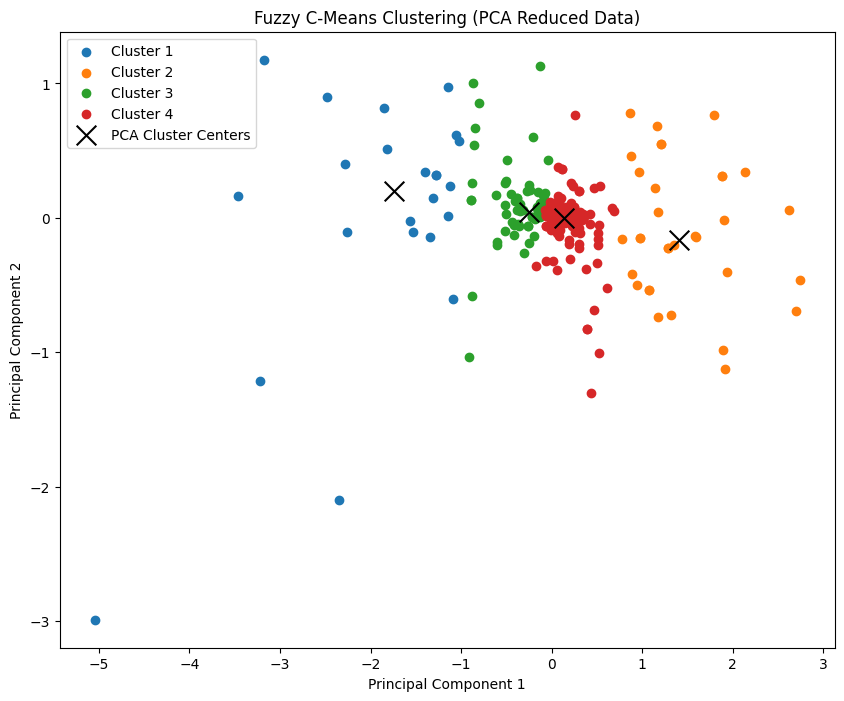

heatmap plot


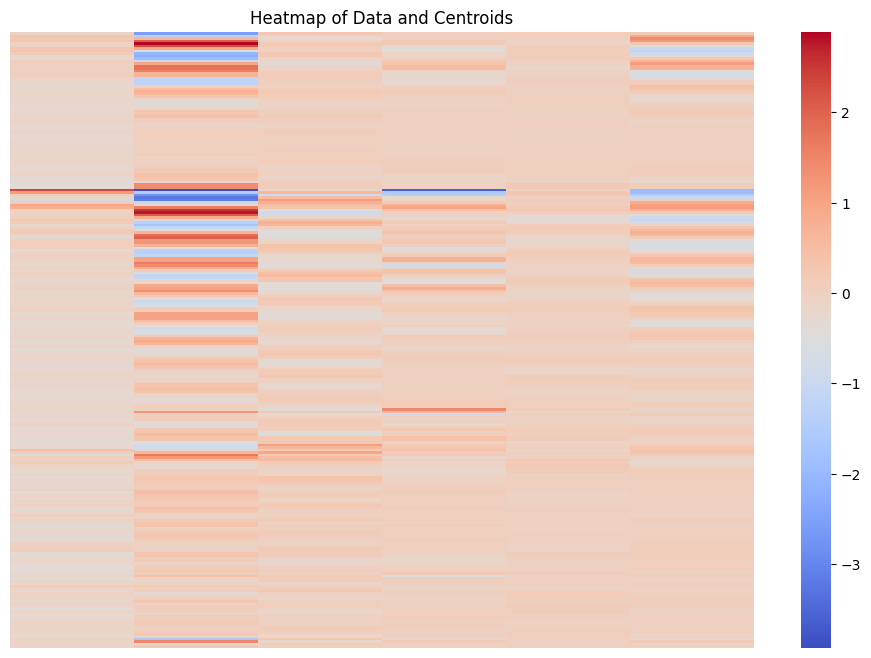

TSNE plot


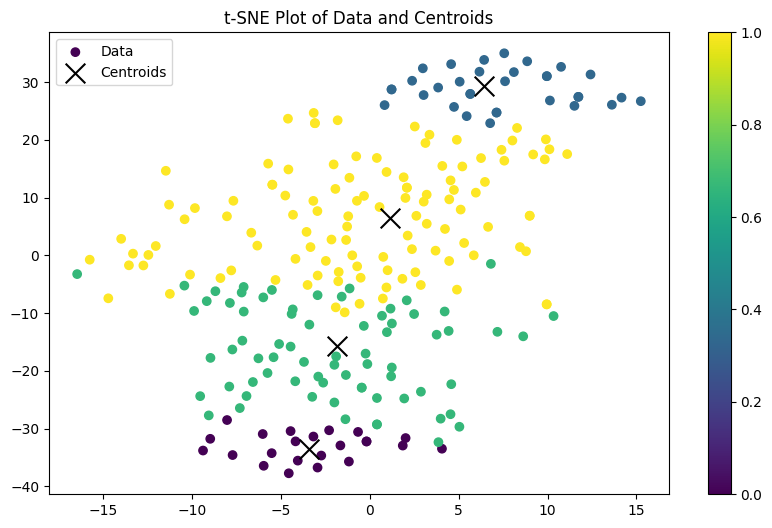

MDS plot


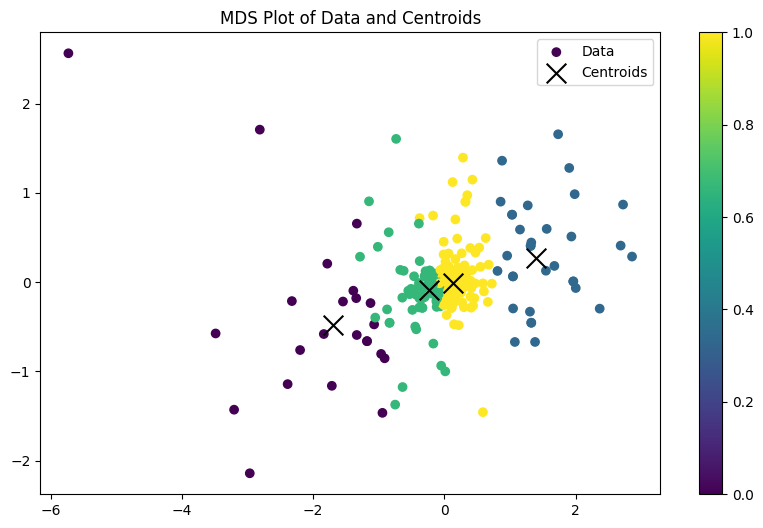

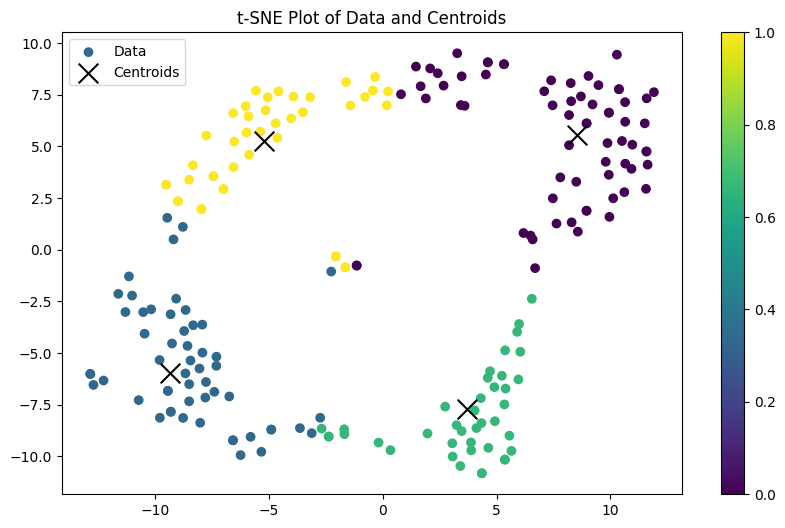

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.17399812006994056
Davies-Bouldin Score: 1.630716199417826
Rand Score: 0.6338858464616154
Tested fpc: 0.36295275422486506
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  1
Liczba klastrów:  4


Processing:   9%|███████████████▎                                                                                                                                                         | 2/22 [00:00<?, ?it/s]


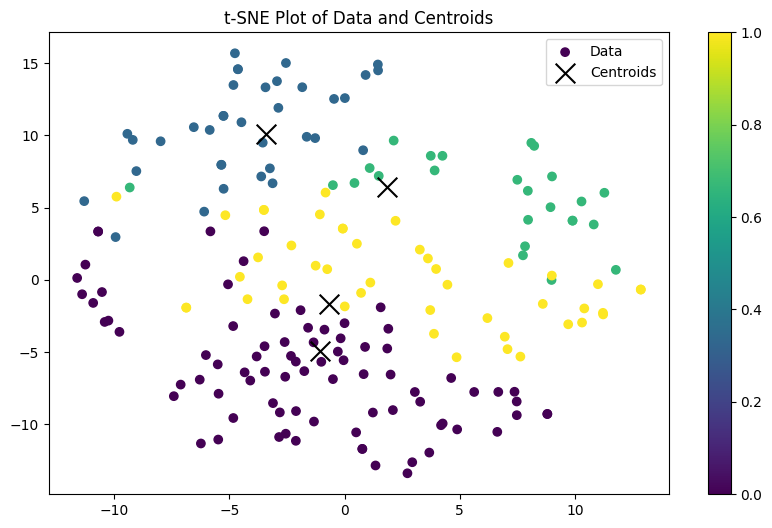

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.34335486166930795
Davies-Bouldin Score: 1.738143104373563
Rand Score: 0.5388229557389347
Tested fpc: 0.4545740381483526
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  2
Liczba klastrów:  4


Processing:  14%|███████████████████████                                                                                                                                                  | 3/22 [00:00<?, ?it/s]


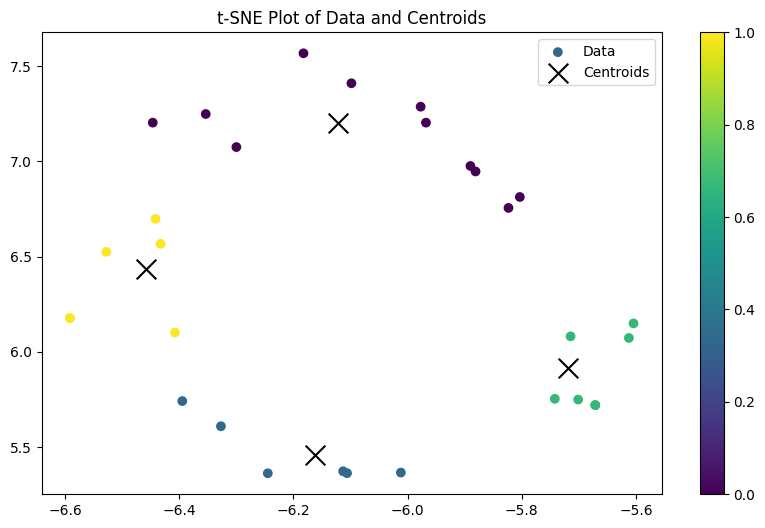

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.20185226277895707
Davies-Bouldin Score: 1.4434684719411195
Rand Score: 0.6126287821955488
Tested fpc: 0.3456317544319602
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  3
Liczba klastrów:  4


Processing:  18%|██████████████████████████████▋                                                                                                                                          | 4/22 [00:00<?, ?it/s]


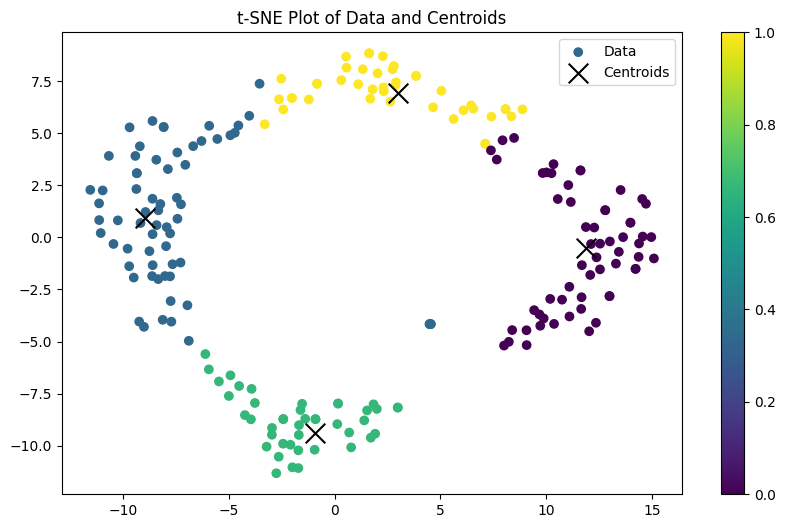

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.19371972548286587
Davies-Bouldin Score: 1.7161755806709682
Rand Score: 0.5947770692673169
Tested fpc: 0.36255107830950284
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  4
Liczba klastrów:  4


Processing:  23%|██████████████████████████████████████▍                                                                                                                                  | 5/22 [00:00<?, ?it/s]


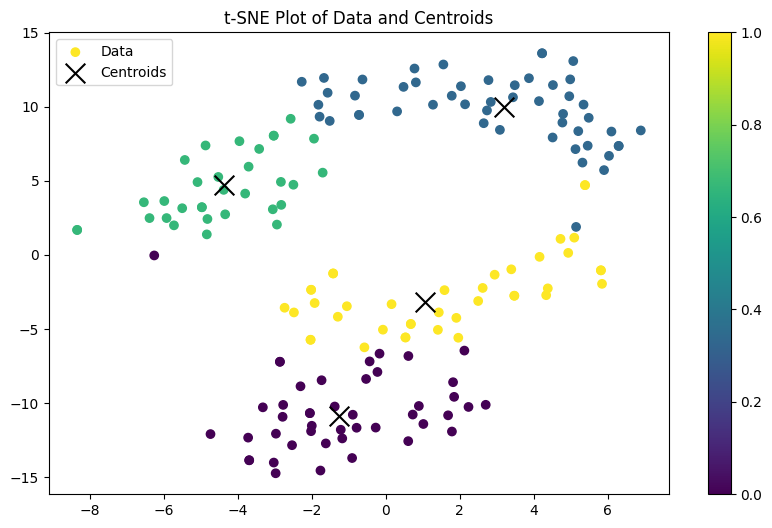

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.050352310400371476
Davies-Bouldin Score: 2.1544340486035827
Rand Score: 0.6603217054263566
Tested fpc: 0.3368048645698975
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  5
Liczba klastrów:  4


Processing:  27%|██████████████████████████████████████████████                                                                                                                           | 6/22 [00:00<?, ?it/s]


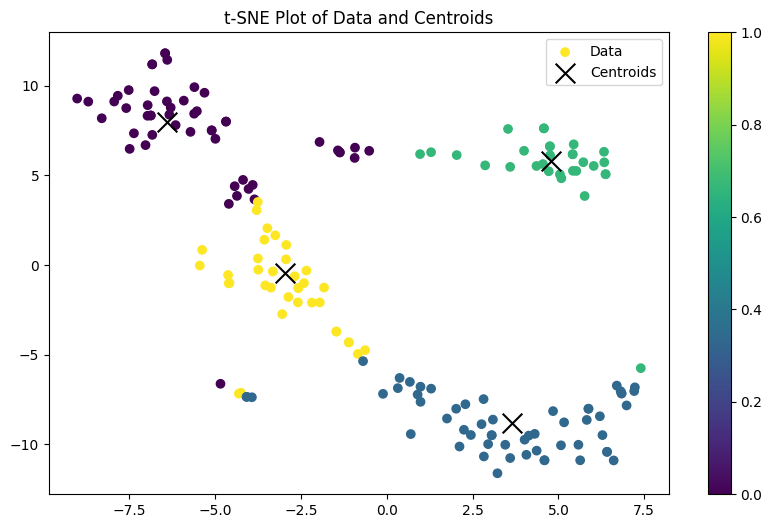

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.19469924206439787
Davies-Bouldin Score: 1.4846524226509525
Rand Score: 0.6155165041260315
Tested fpc: 0.36622390700411417
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  6
Liczba klastrów:  4


Processing:  32%|█████████████████████████████████████████████████████▊                                                                                                                   | 7/22 [00:00<?, ?it/s]


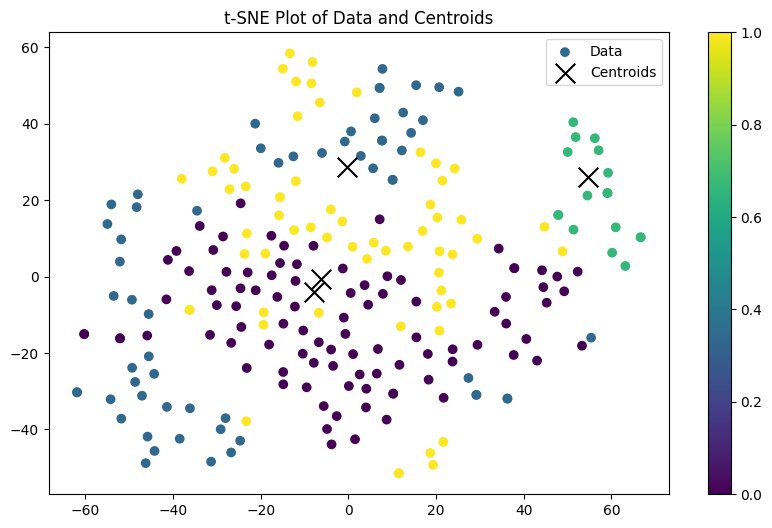

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.15185344034576162
Davies-Bouldin Score: 2.060765165187747
Rand Score: 0.6067490622655664
Tested fpc: 0.3762731103016389
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  7
Liczba klastrów:  4


Processing:  36%|█████████████████████████████████████████████████████████████▍                                                                                                           | 8/22 [00:00<?, ?it/s]


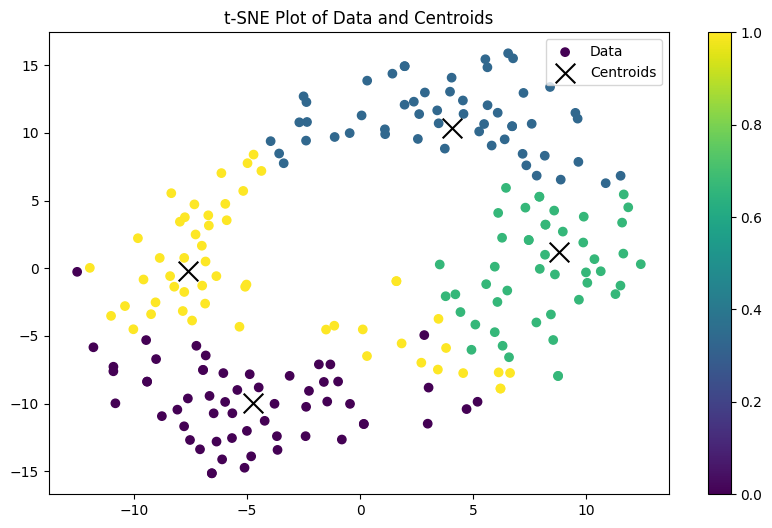

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.11427426408510823
Davies-Bouldin Score: 1.8175201175492401
Rand Score: 0.6784112278069517
Tested fpc: 0.3562693989058407
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  8
Liczba klastrów:  4


Processing:  41%|█████████████████████████████████████████████████████████████████████▏                                                                                                   | 9/22 [00:00<?, ?it/s]


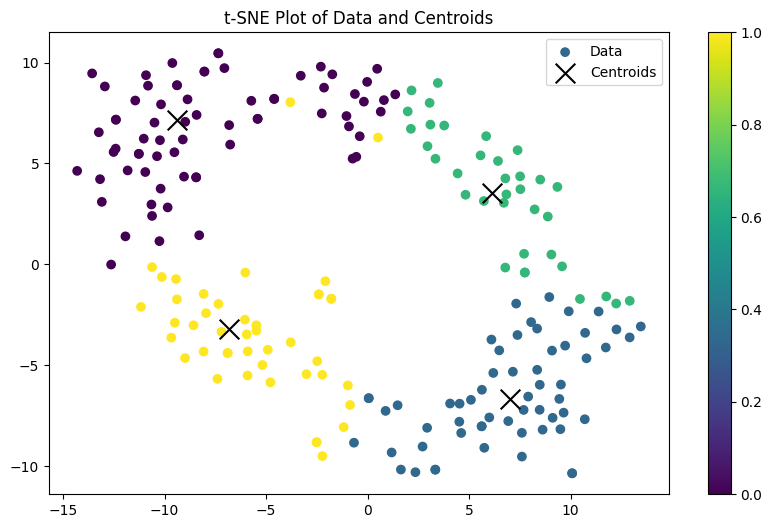

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.11704349343061758
Davies-Bouldin Score: 1.8382603444117227
Rand Score: 0.6753087021755438
Tested fpc: 0.35241461398596935
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  9
Liczba klastrów:  4


Processing:  45%|████████████████████████████████████████████████████████████████████████████▎                                                                                           | 10/22 [00:00<?, ?it/s]


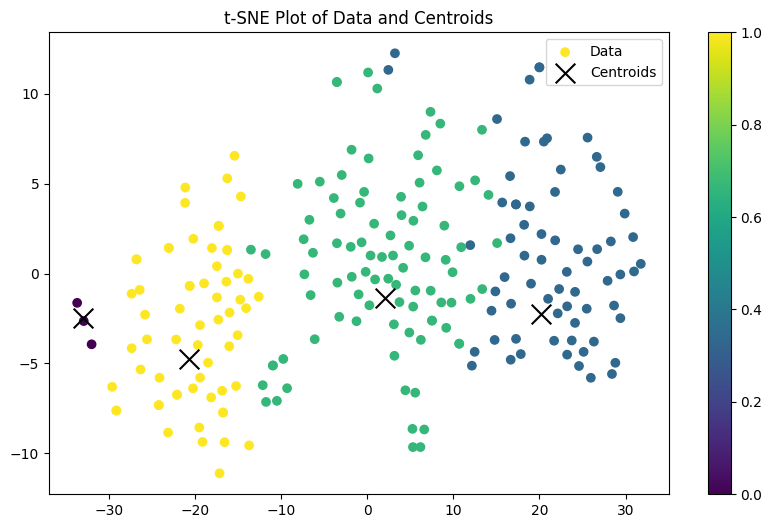

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: -0.09692875544113279
Davies-Bouldin Score: 1.7596006587540343
Rand Score: 0.6430186296574144
Tested fpc: 0.34132811313258193
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  10
Liczba klastrów:  4


Processing:  50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 11/22 [00:00<?, ?it/s]


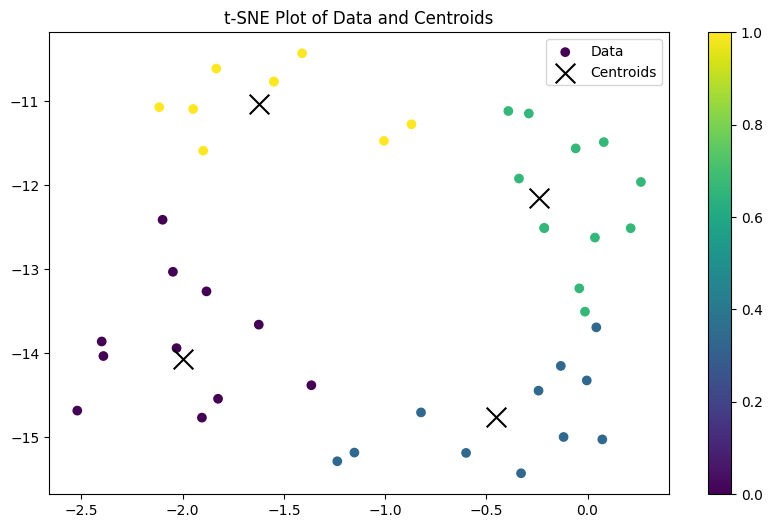

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.09876285907188492
Davies-Bouldin Score: 1.8145578075374302
Rand Score: 0.6679101025256314
Tested fpc: 0.33188577088074617
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  11
Liczba klastrów:  4


Processing:  55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 12/22 [00:00<?, ?it/s]


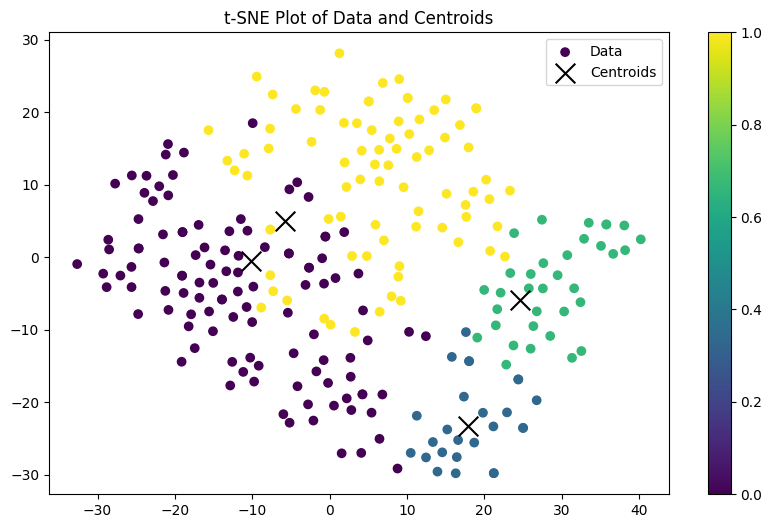

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.2930633867150011
Davies-Bouldin Score: 1.2575943369258202
Rand Score: 0.6387268067016754
Tested fpc: 0.445669375336854
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  12
Liczba klastrów:  4


Processing:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 13/22 [00:00<?, ?it/s]


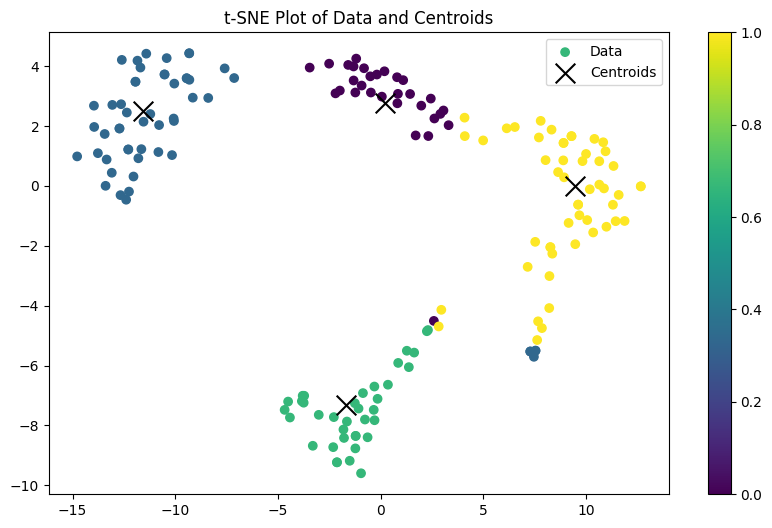

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.16750521095721677
Davies-Bouldin Score: 1.555067057112504
Rand Score: 0.6195855213803451
Tested fpc: 0.36547662984723045
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  13
Liczba klastrów:  4


Processing:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 14/22 [00:00<?, ?it/s]


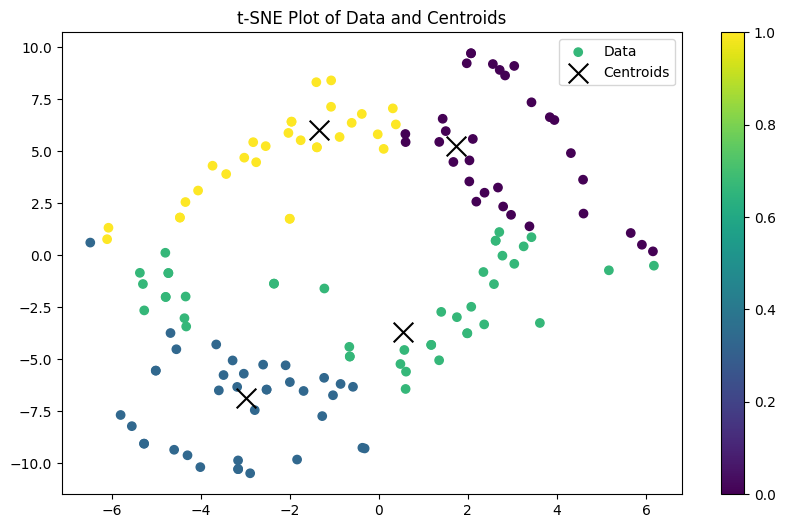

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: -0.05180759769150967
Davies-Bouldin Score: 2.227236490382357
Rand Score: 0.6638563390847712
Tested fpc: 0.3129863572970489
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  14
Liczba klastrów:  4


Processing:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 15/22 [00:00<?, ?it/s]


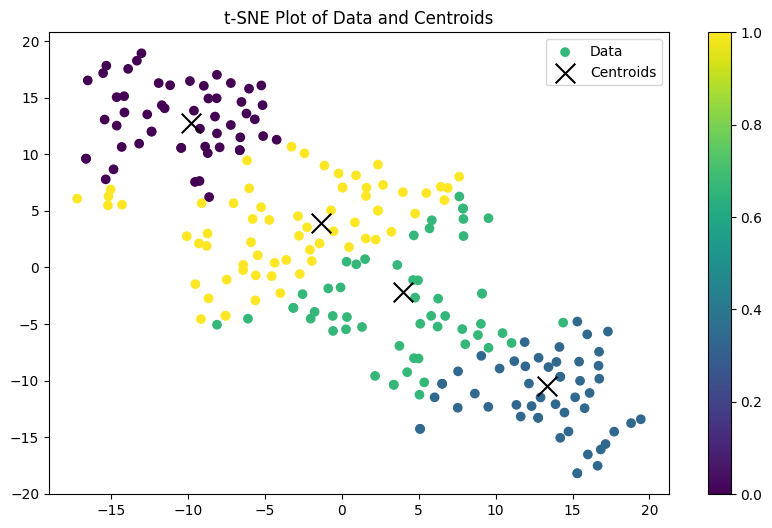

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: -0.17371485901630973
Davies-Bouldin Score: 3.8745100759853965
Rand Score: 0.6340708927231808
Tested fpc: 0.3148114545232586
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  15
Liczba klastrów:  4


Processing:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 16/22 [00:00<?, ?it/s]


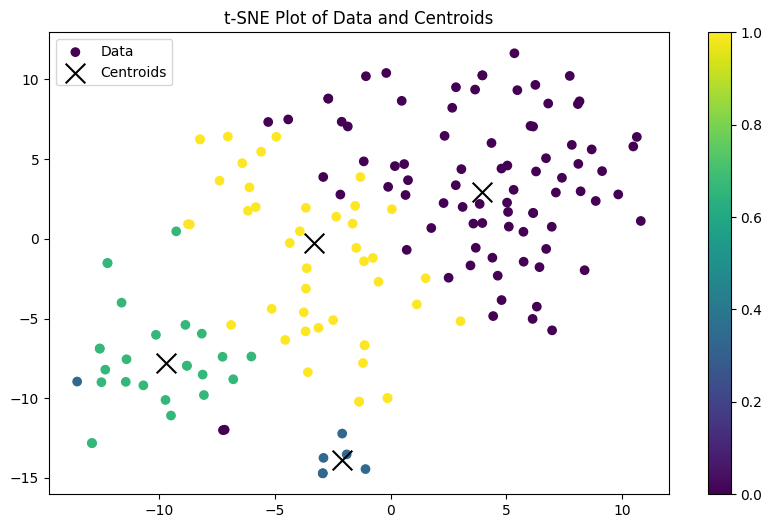

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.4287713895868958
Davies-Bouldin Score: 1.2792536361279452
Rand Score: 0.5483142035508877
Tested fpc: 0.5826730231577006
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  16
Liczba klastrów:  4


Processing:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 17/22 [00:00<?, ?it/s]


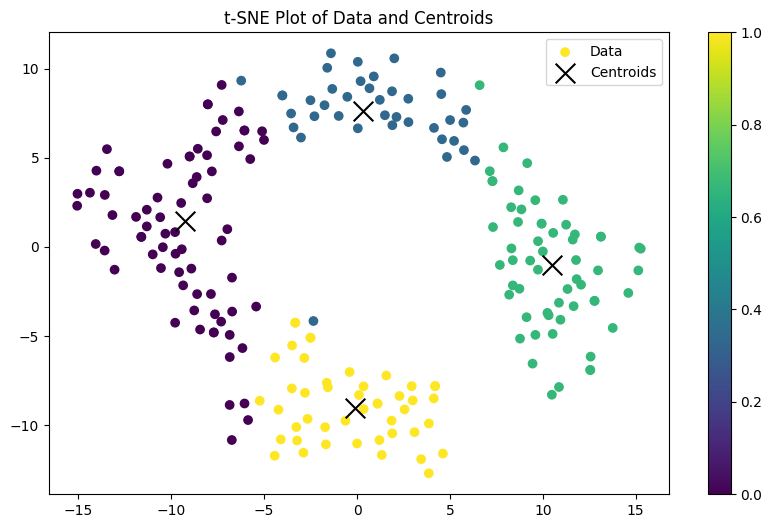

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.04497189936429024
Davies-Bouldin Score: 2.2400729769192793
Rand Score: 0.6557969492373094
Tested fpc: 0.34518772585965996
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  17
Liczba klastrów:  4


Processing:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 18/22 [00:00<?, ?it/s]


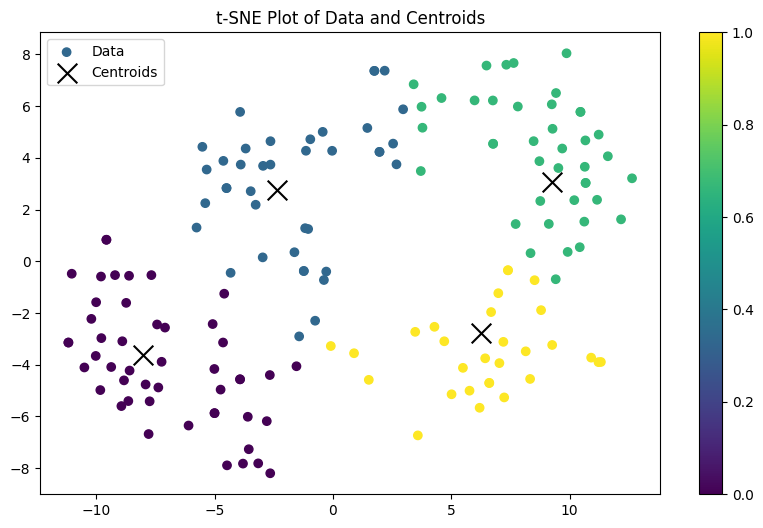

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.16529689078182275
Davies-Bouldin Score: 1.7621850139880437
Rand Score: 0.6804227306826707
Tested fpc: 0.3637306533120078
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  18
Liczba klastrów:  4


Processing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 19/22 [00:00<?, ?it/s]


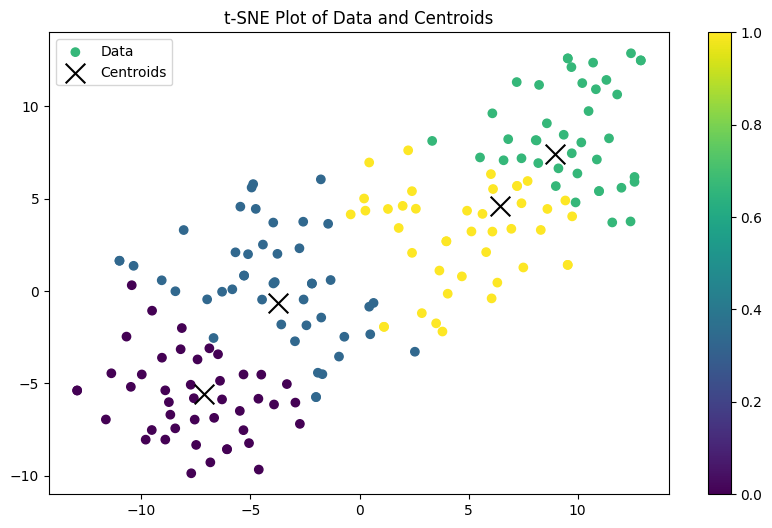

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: -0.22483678156289127
Davies-Bouldin Score: 2.6731375664369947
Rand Score: 0.590840335083771
Tested fpc: 0.2812092808812583
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  19
Liczba klastrów:  4


Processing:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 20/22 [00:00<?, ?it/s]


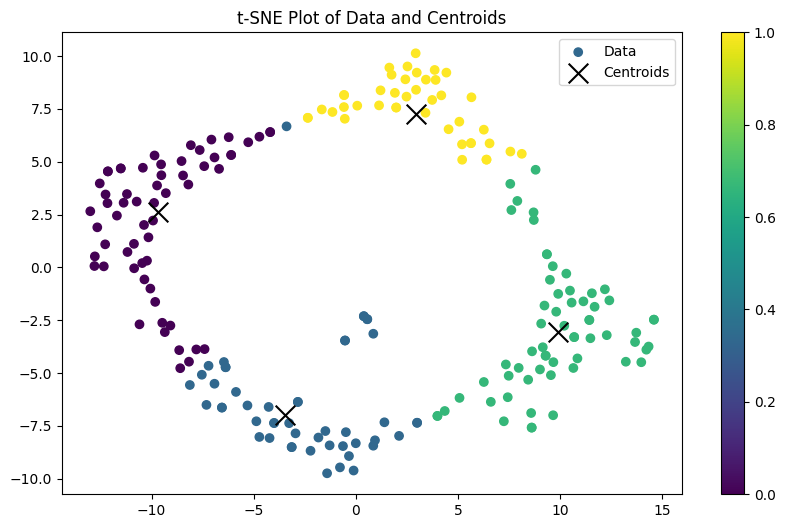

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.2251913891901114
Davies-Bouldin Score: 1.6094969239898766
Rand Score: 0.6378553388347087
Tested fpc: 0.35985959753955415
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  20
Liczba klastrów:  4


Processing:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 21/22 [00:00<?, ?it/s]


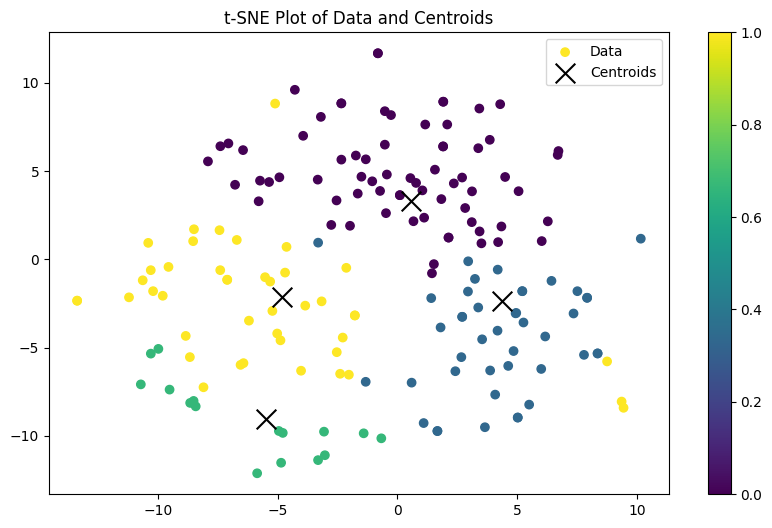

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.3744083879408469
Davies-Bouldin Score: 1.380607434479341
Rand Score: 0.6043525881470367
Tested fpc: 0.5033654616695693
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  21
Liczba klastrów:  4


Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<?, ?it/s]


In [41]:
diagnosis_chunk, diagnosis_iterations = train_incremental_fuzzy_cmeans(n_clusters, chunks, chunks_test, chunks_test_y, visualise_data=True, plot_func=plot_tsne)

Historia danych ze względu na kolejne chunki


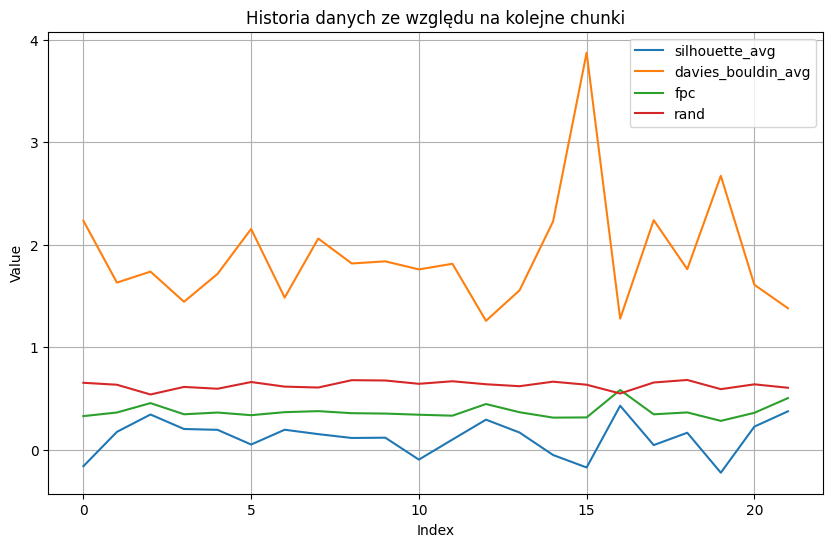

Historia danych wewnatrz iteracji dla pierwszego chunka


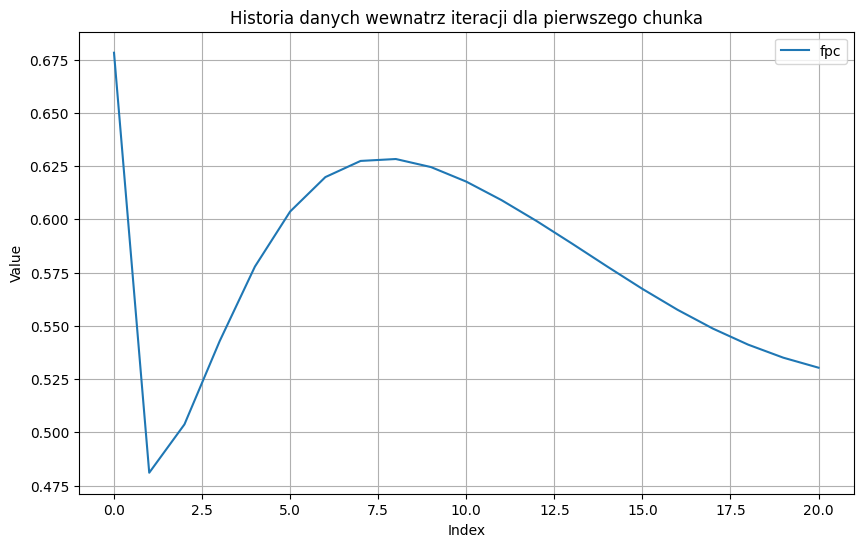

Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku


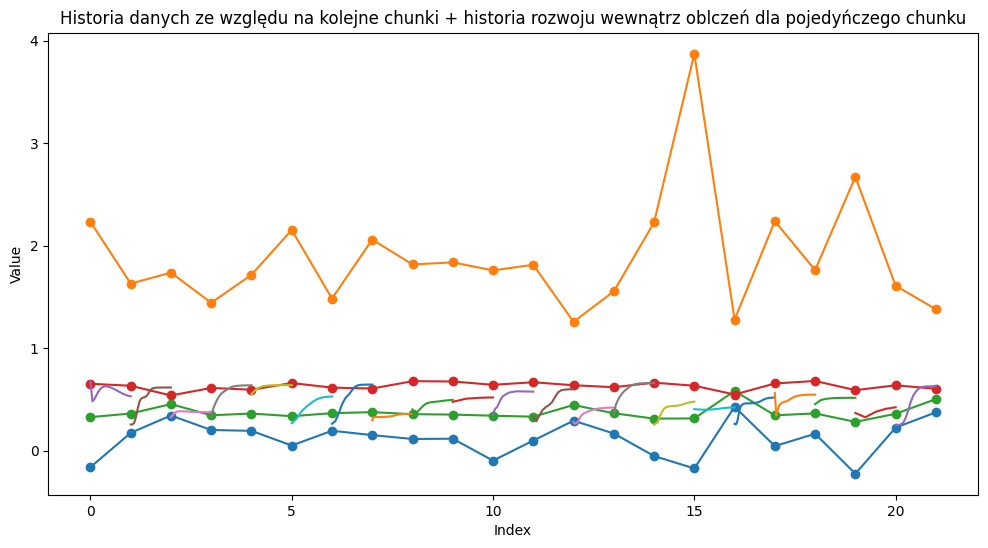

Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku


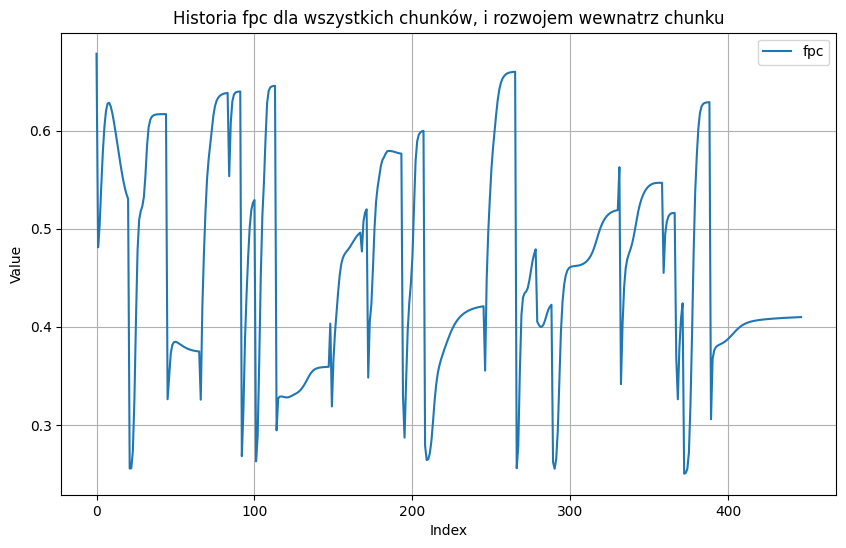

chunk_length_train 200
chunk_length_test 100
n_clusters 4
m 2.0


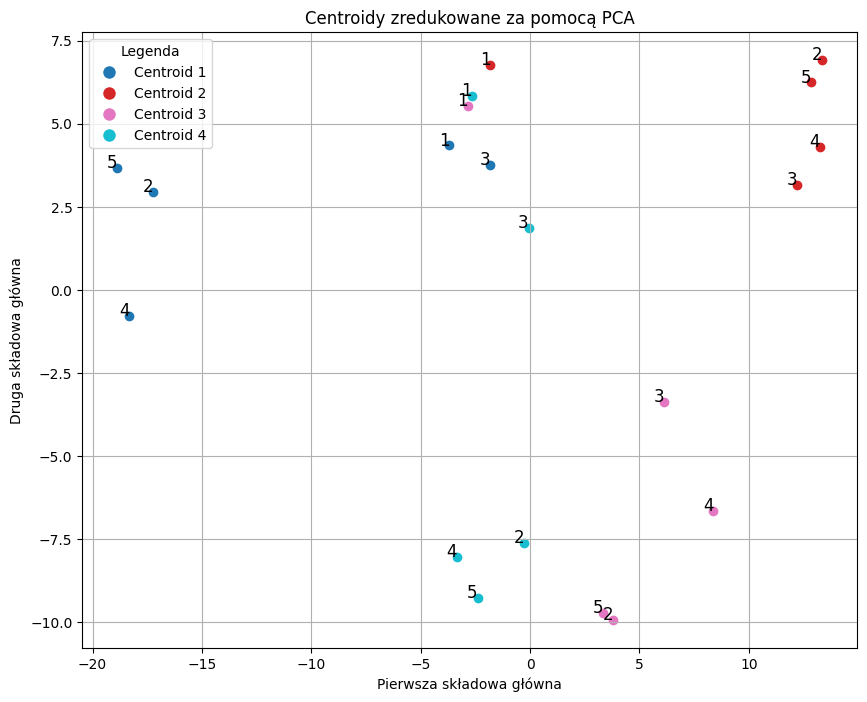

fpc last 0.5033654616695693
rand last 0.6043525881470367


In [42]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Trenowanie przy pomocy iterowania się po chunkach z rozszerzającymi się danymi

In [43]:
diagnosis_chunk, diagnosis_iterations = train_incremental_fuzzy_cmeans_extending_data(n_clusters, chunks, chunks_test, chunks_test_y)

Rozważamy obecnie chunk numer:  21
Liczba klastrów:  4


Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<?, ?it/s]


Historia danych ze względu na kolejne chunki


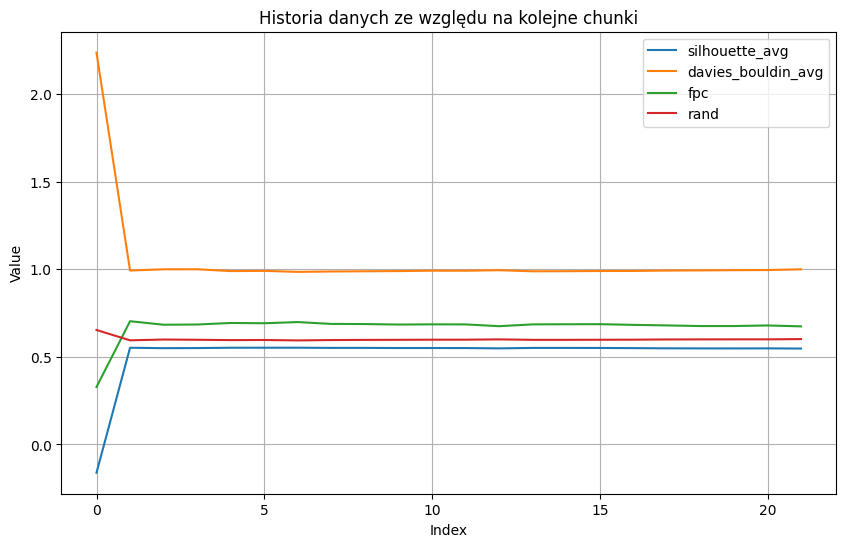

Historia danych wewnatrz iteracji dla pierwszego chunka


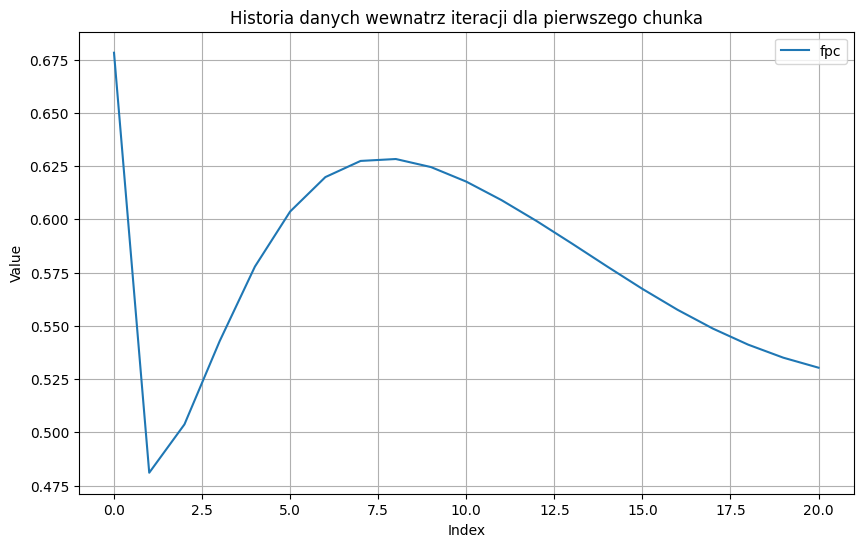

Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku


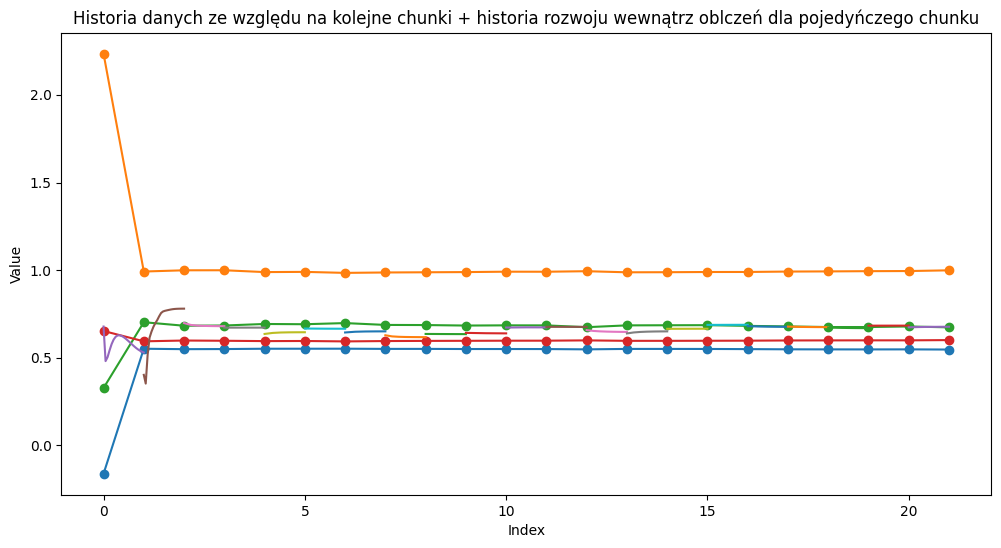

Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku


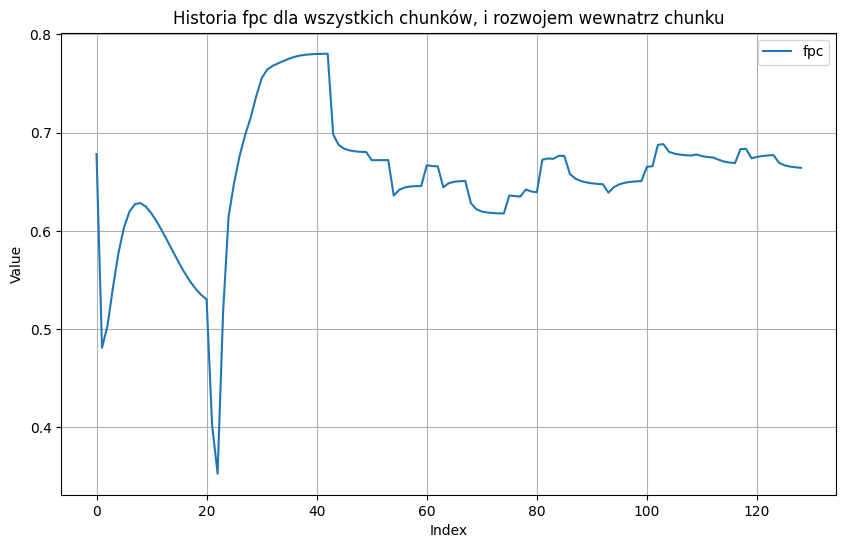

chunk_length_train 200
chunk_length_test 100
n_clusters 4
m 2.0


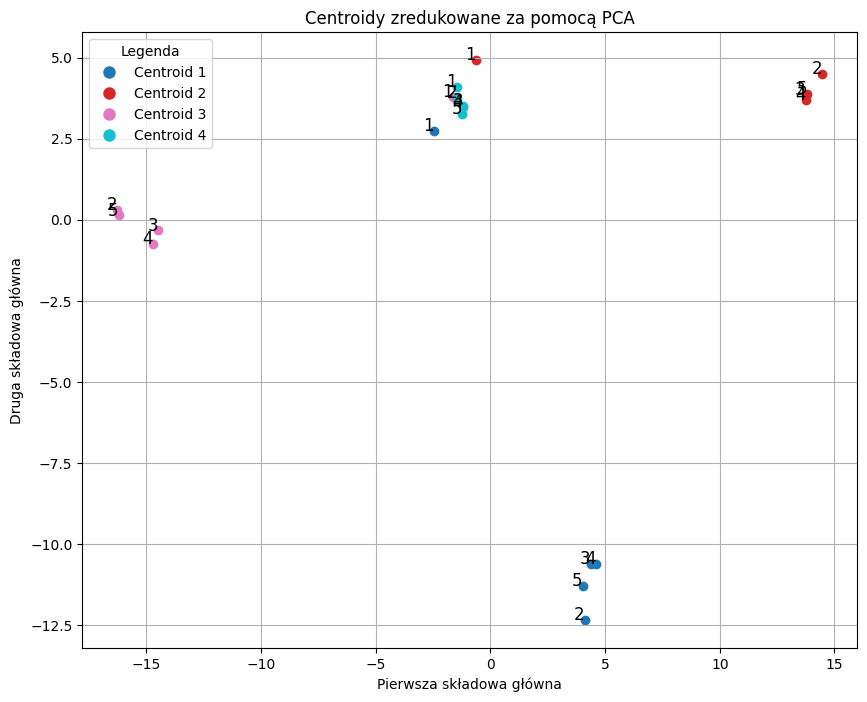

fpc last 0.6735877995962392
rand last 0.6009566141535384


In [44]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Trenowanie przy pomocy iterowania się po chunkach z rozszerzającymi się danymi, przesuwającym się oknem

In [45]:
diagnosis_chunk, diagnosis_iterations = train_incremental_fuzzy_cmeans_extending_window_data(n_clusters, chunks, chunks_test, chunks_test_y)

Rozważamy obecnie chunk numer:  21
Liczba klastrów:  4


Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<?, ?it/s]


Historia danych ze względu na kolejne chunki


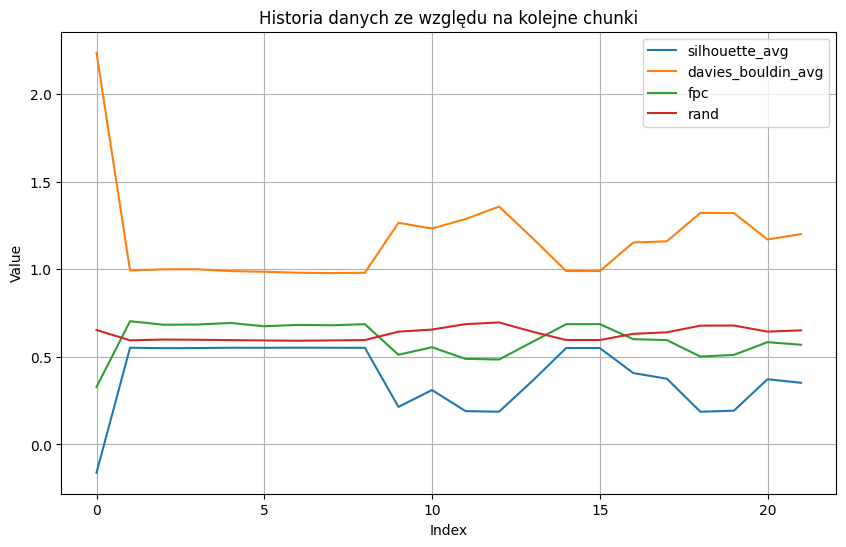

Historia danych wewnatrz iteracji dla pierwszego chunka


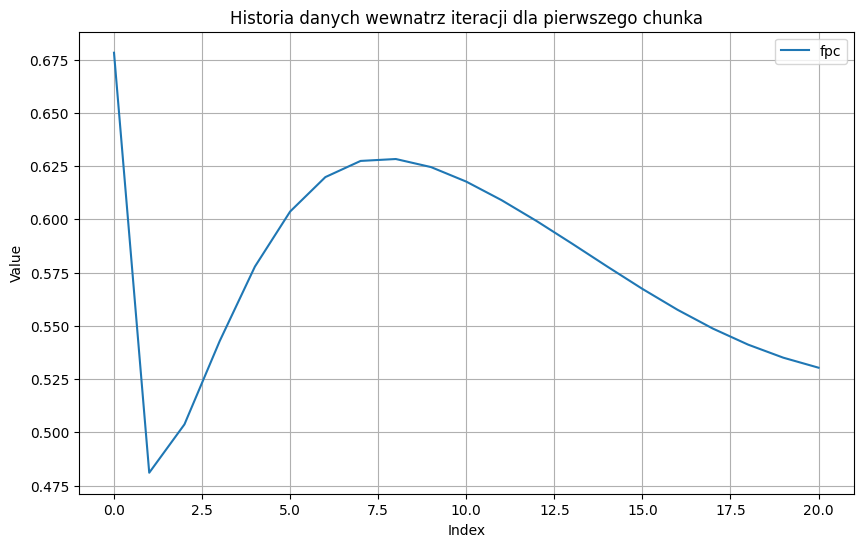

Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku


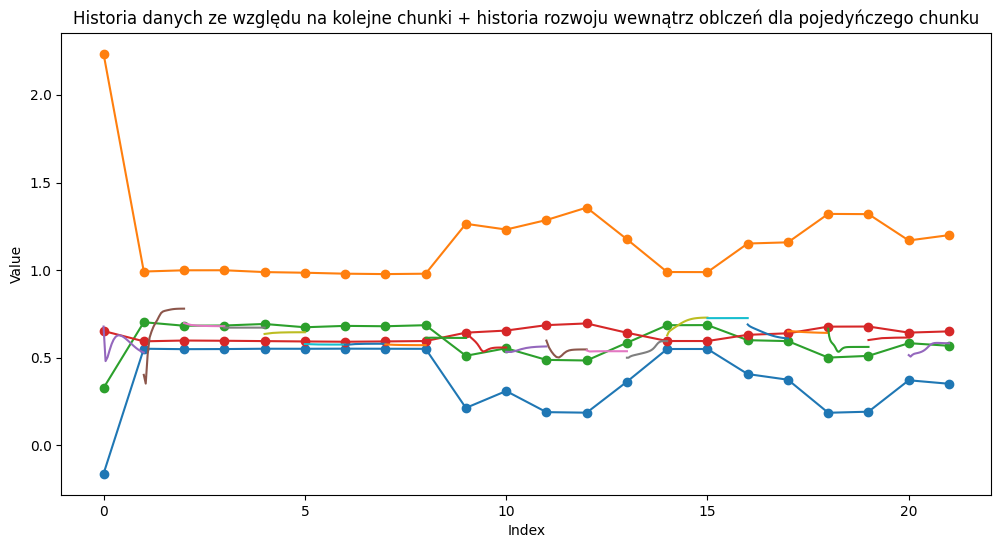

Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku


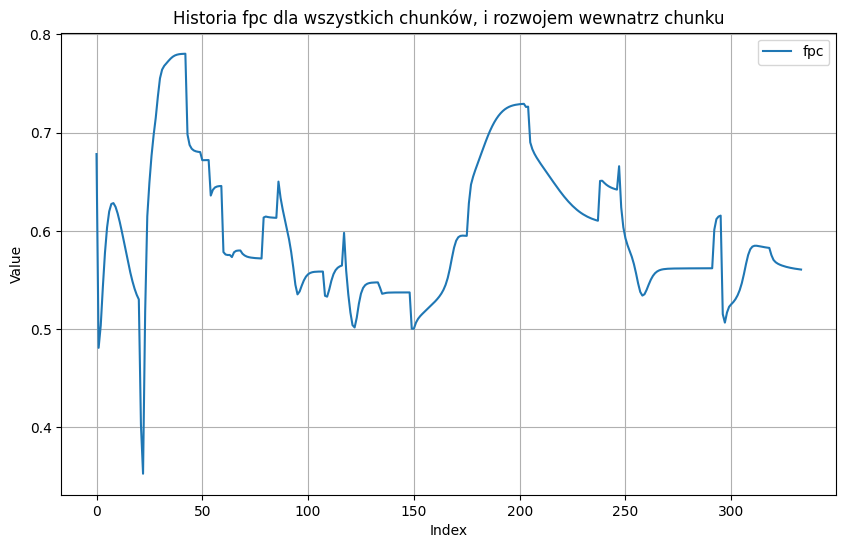

chunk_length_train 200
chunk_length_test 100
n_clusters 4
m 2.0


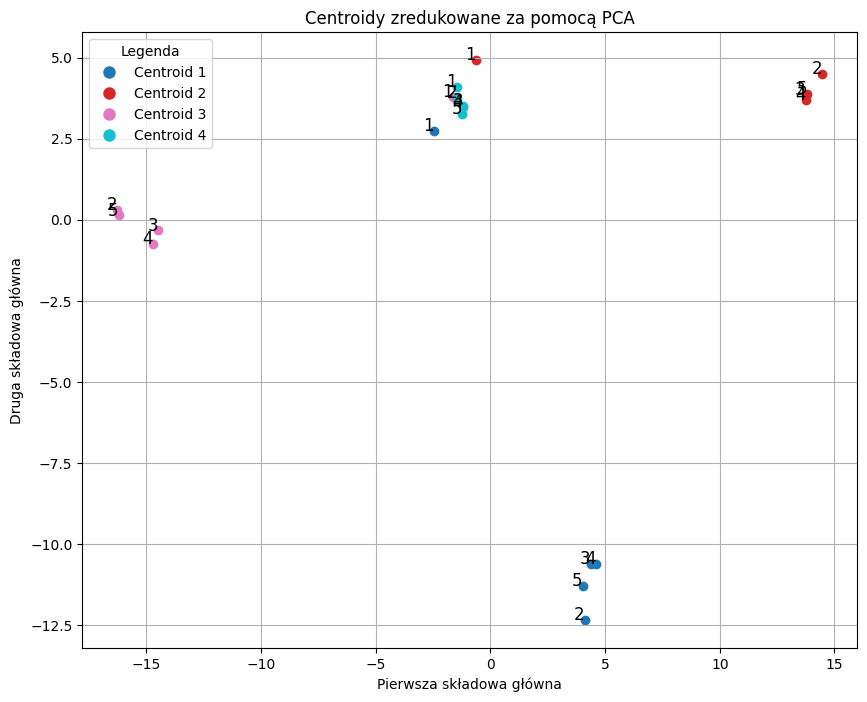

fpc last 0.5684985176012112
rand last 0.650719054763691


In [46]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

### Badania zachowania się metody ze względu na liczbę clustrów



In [47]:
output_data_chunk = []
output_data_iter = []
for n in range(2,10):
    print('Rozważam: ', n)
    diagnosis_tools, diagnosis_iterations = train_incremental_fuzzy_cmeans(n, chunks, chunks_test, chunks_test_y)
    output_data_chunk.append(diagnosis_tools)
    output_data_iter.append(diagnosis_iterations)

Rozważamy obecnie chunk numer:  21
Liczba klastrów:  9


Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<?, ?it/s]


In [48]:
plot_statistic = DiagnosisTools()

for n in range(2,10):
    sil, dave, fpc, rand = output_data_chunk[n-2].get_avg()
    plot_statistic.add_elements(sil, dave, fpc, rand)

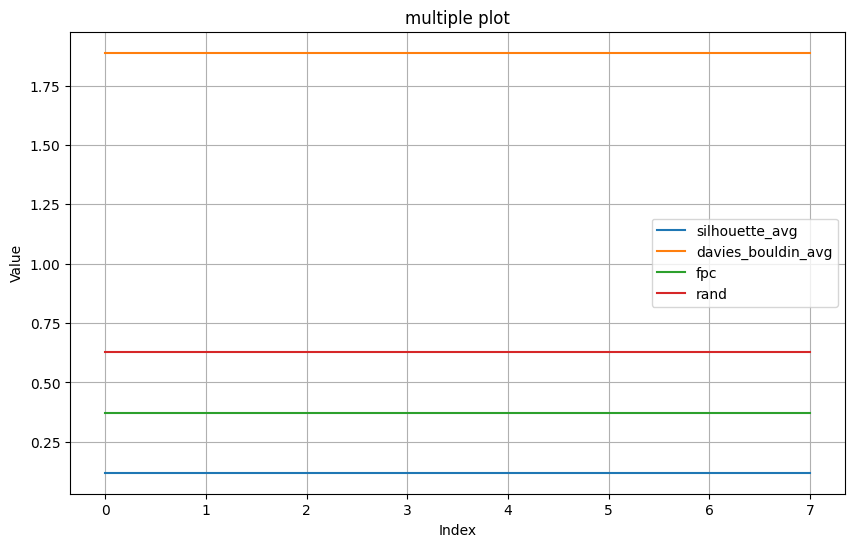

In [49]:
plot_statistic.plot_lists()

# Testowanie algorytmu ISSFCM

### Trenowanie przy pomocy dodawania kolejnych chunków

In [50]:
# Funkcja liczy centroidy dla kolejnych chunków, centroidy są przekazywane jako parametr inicjalizacyjny dla kolejnych iteracji algorytmu.
# Liczba punktów w algorytmie jest stała, do kolejnej iteracji algorytmu poprzednie punkty są zapominane.
# Input:
#       n_clusters - liczba centroidów
#       chunks - dane w postaci listy chunków
#       chunks_y - lista chunków labeli odpowiadających chunks. Labele nie są postaci listy tylko macierzy rozmytych przynależności do danej klasy.
#       validation_data - dane validacyjne
#       validation_y - labele dla danych validacyjnych
def train_incremental_semi_supervised_fuzzy_cmeans(n_clusters, chunks, chunks_y, validation_data, validation_y, visualise_data=False, plot_func=plot_pca, metric='euclidean', init_centroids=init_centroids):    
    # Inicjalizacjia multi listy, która będzie zbierać potrzbne statystki
    diagnosis_tools = DiagnosisTools()
    diagnosis_iterations = []

    data = chunks[0]
    y_supervised = chunks_y[0]

    centroids, fuzzy_labels, dist, p, fpc, statistics = incremental_semi_supervised_fuzzy_cmeans(data, y_supervised, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = 'euclidean', init_centroid=None)

    silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data_issfcm(validation_data, centroids, validation_y, m, g_error)
    diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
    diagnosis_tools.add_centroids(centroids)
    diagnosis_iterations.append(statistics)

    # Wizualizacja dla pierwszej iteracji
    if(visualise_data):
        visualize_all(data, centroids, fuzzy_labels)
    
    # Kolejne trenowanie modelu
    for count, data in enumerate(chunks):
        # Pomijamy pierwszy chunk, bo już go uwzględniliśmy
        if count == 0:
            continue
            
        y_supervised = chunks_y[count]

        centroids, fuzzy_labels, dist, p, fpc, diagnosis_iteration = incremental_semi_supervised_fuzzy_cmeans(data, y_supervised, c = n_clusters, m = m, error=g_error, maxiter=1000, metric = 'euclidean', init_centroid=None)

        if(visualise_data):
            plot_func(data, centroids, fuzzy_labels)

        # Validacja danych
        silhouette_avg, davies_bouldin_avg, rand, fpc_test = valid_data_issfcm(validation_data, centroids, validation_y, m, g_error, metric)
        diagnosis_tools.add_elements(silhouette_avg, davies_bouldin_avg, fpc_test, rand)
        diagnosis_tools.add_centroids(centroids)

        diagnosis_iterations.append(diagnosis_iteration)
        
        # Czyszczenie poprzedniego outputu
        if(visualise_data == False):
            clear_output(wait=True)
        
        # Wyświetlanie paska postępu
        print('Rozważamy obecnie chunk numer: ', count)
        print('Liczba klastrów: ', n_clusters)
        tqdm(range(len(chunks)), desc="Processing", total=len(chunks), initial=count + 1)
        
    return diagnosis_tools, diagnosis_iterations

Silhouette Score: -0.17077175023666616
Davies-Bouldin Score: 2.2572414045466984
Rand Score: 0.6501045261315329
Tested fpc: 0.32450074750631824
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
PCA plot


C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


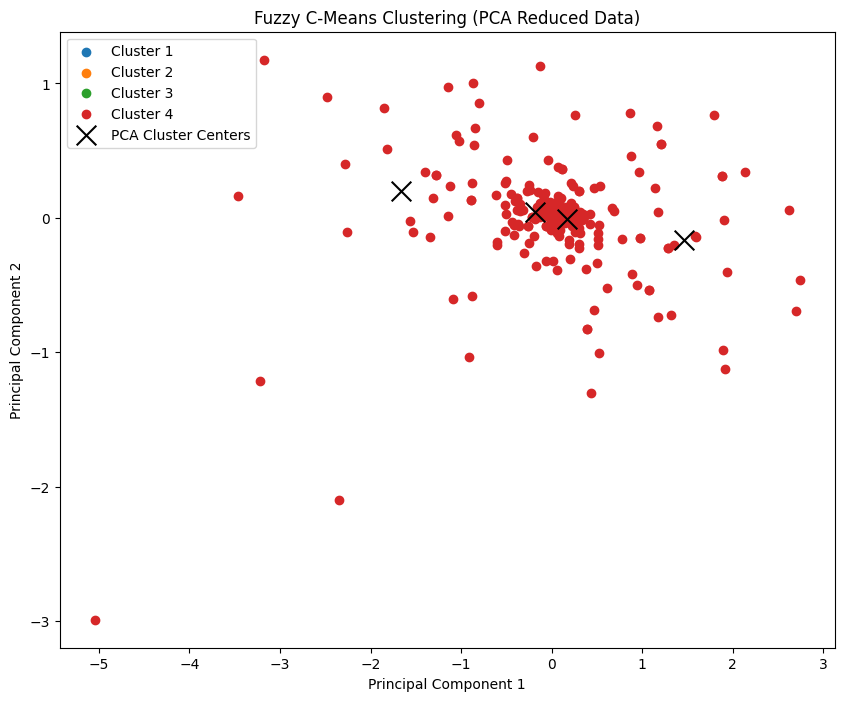

heatmap plot


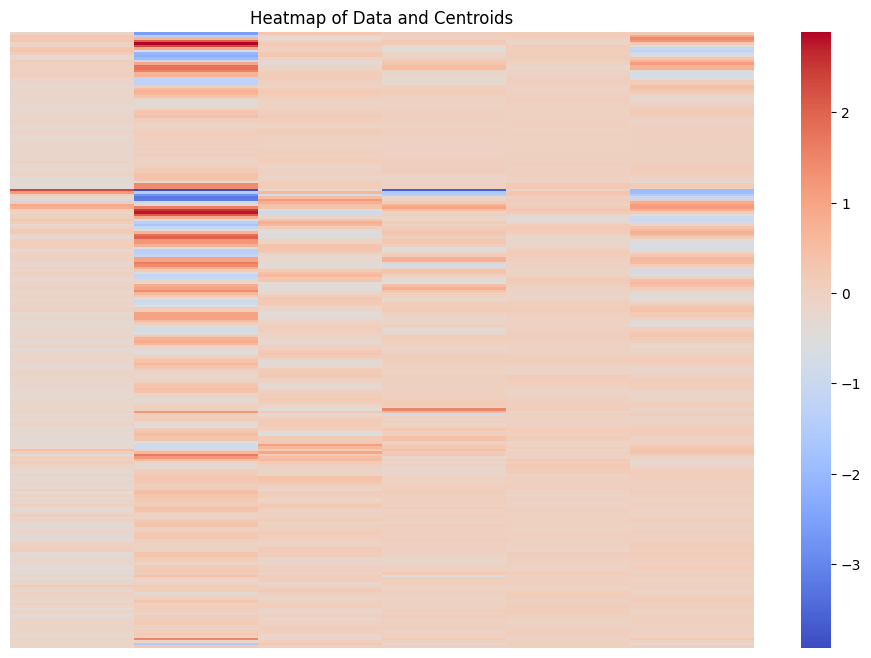

TSNE plot


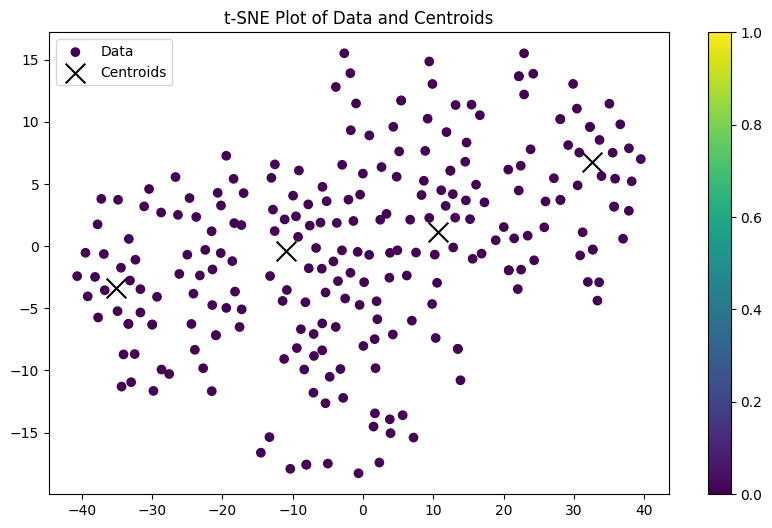

MDS plot


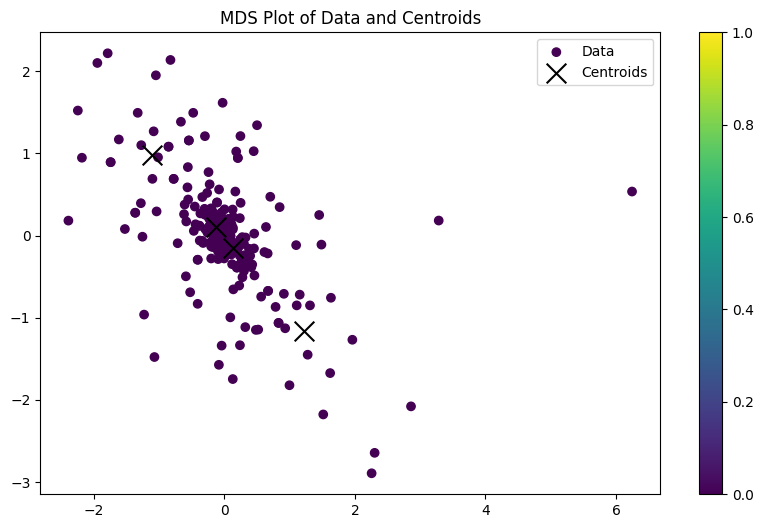

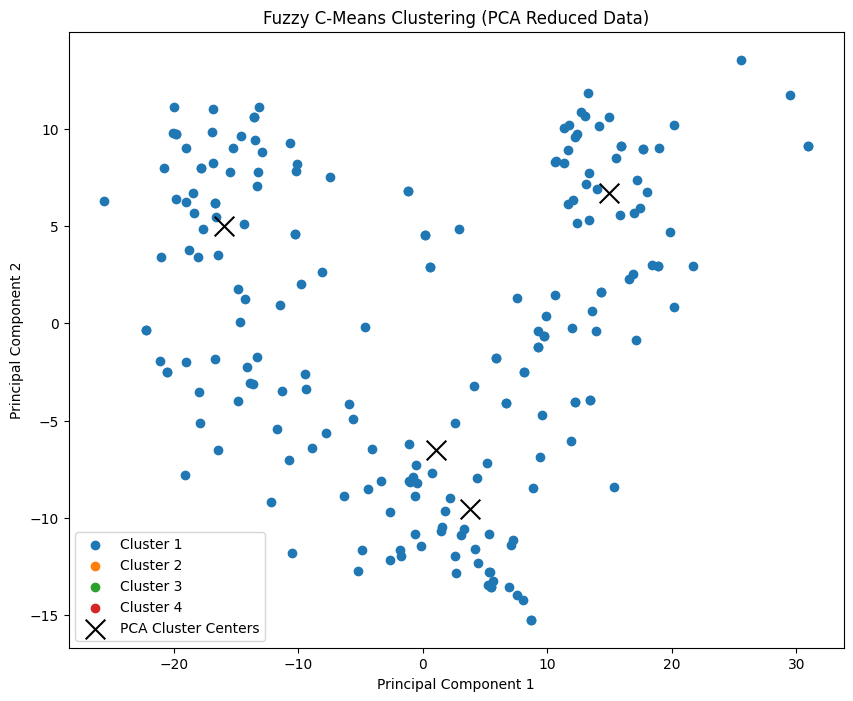

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.17027939140830523
Davies-Bouldin Score: 1.6450893292298716
Rand Score: 0.6334434858714678
Tested fpc: 0.3624862743761914
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  1
Liczba klastrów:  4


Processing:   9%|███████████████▎                                                                                                                                                         | 2/22 [00:00<?, ?it/s]


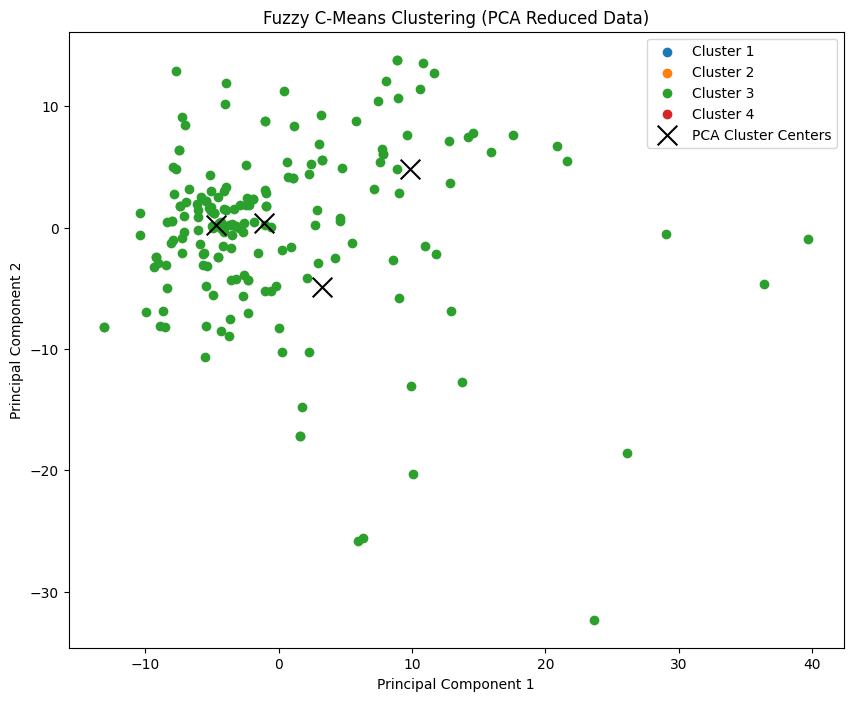

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.2664283576506313
Davies-Bouldin Score: 1.4058943095723755
Rand Score: 0.5361519129782446
Tested fpc: 0.48322515985627973
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  2
Liczba klastrów:  4


Processing:  14%|███████████████████████                                                                                                                                                  | 3/22 [00:00<?, ?it/s]


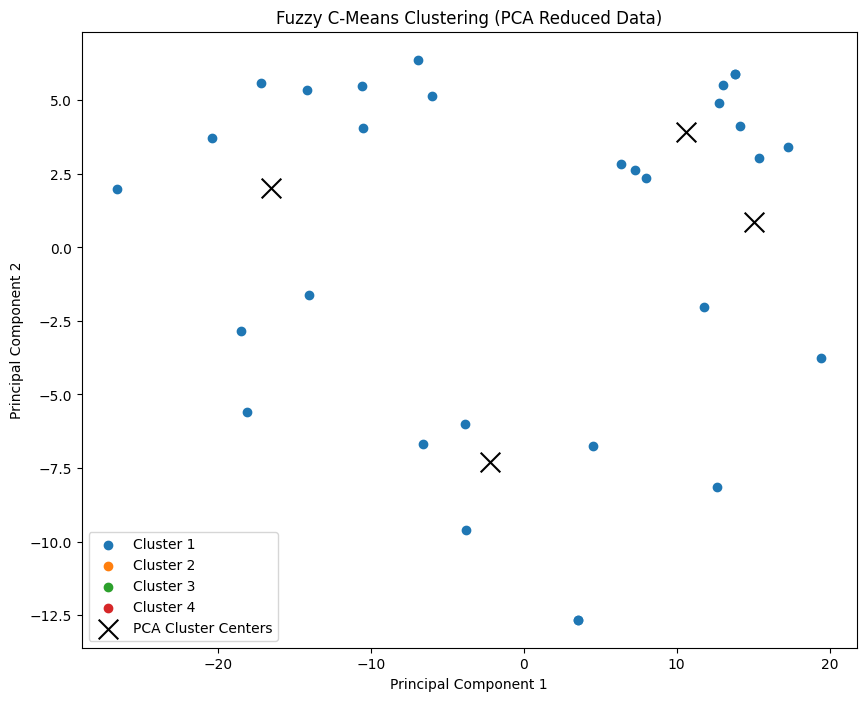

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.2496586212236678
Davies-Bouldin Score: 1.3491851158736745
Rand Score: 0.6039053513378344
Tested fpc: 0.345605710826036
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  3
Liczba klastrów:  4


Processing:  18%|██████████████████████████████▋                                                                                                                                          | 4/22 [00:00<?, ?it/s]


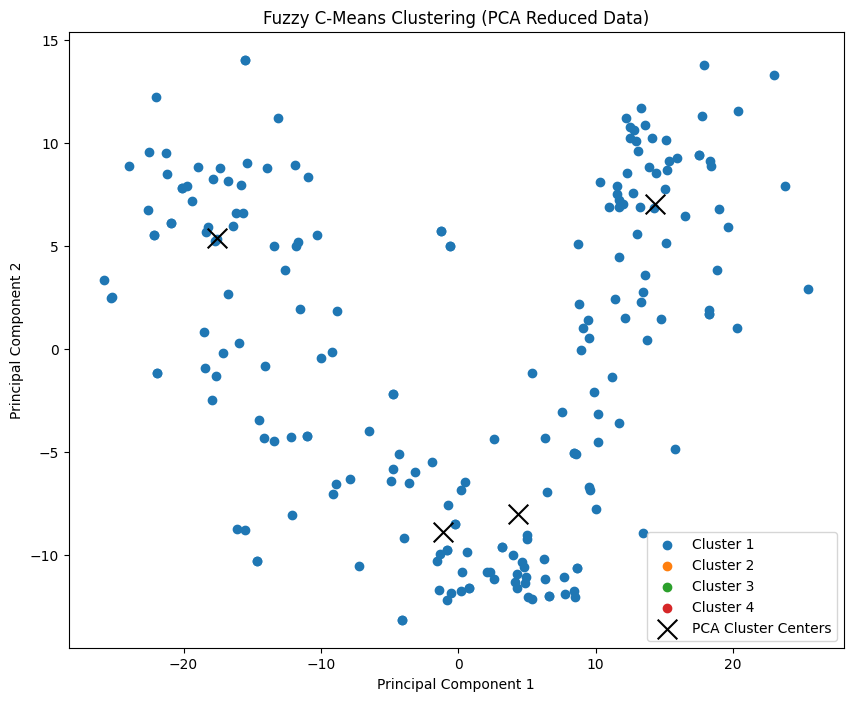

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.19540744872828916
Davies-Bouldin Score: 1.7185385466275704
Rand Score: 0.5954214803700926
Tested fpc: 0.36242067729800087
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  4
Liczba klastrów:  4


Processing:  23%|██████████████████████████████████████▍                                                                                                                                  | 5/22 [00:00<?, ?it/s]


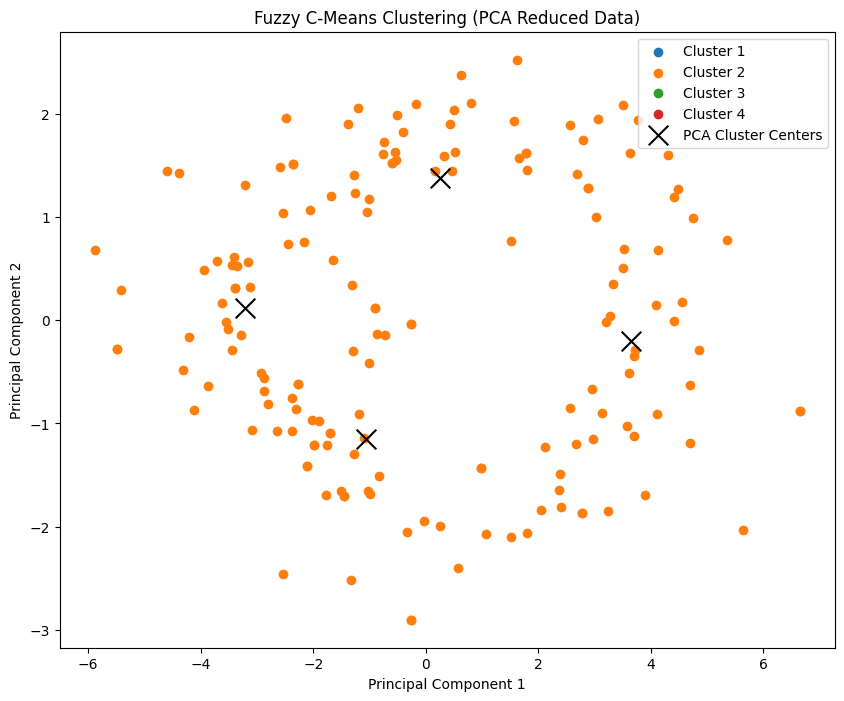

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.04148484940880029
Davies-Bouldin Score: 2.271468411114756
Rand Score: 0.6549118529632408
Tested fpc: 0.3355575633722861
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  5
Liczba klastrów:  4


Processing:  27%|██████████████████████████████████████████████                                                                                                                           | 6/22 [00:00<?, ?it/s]


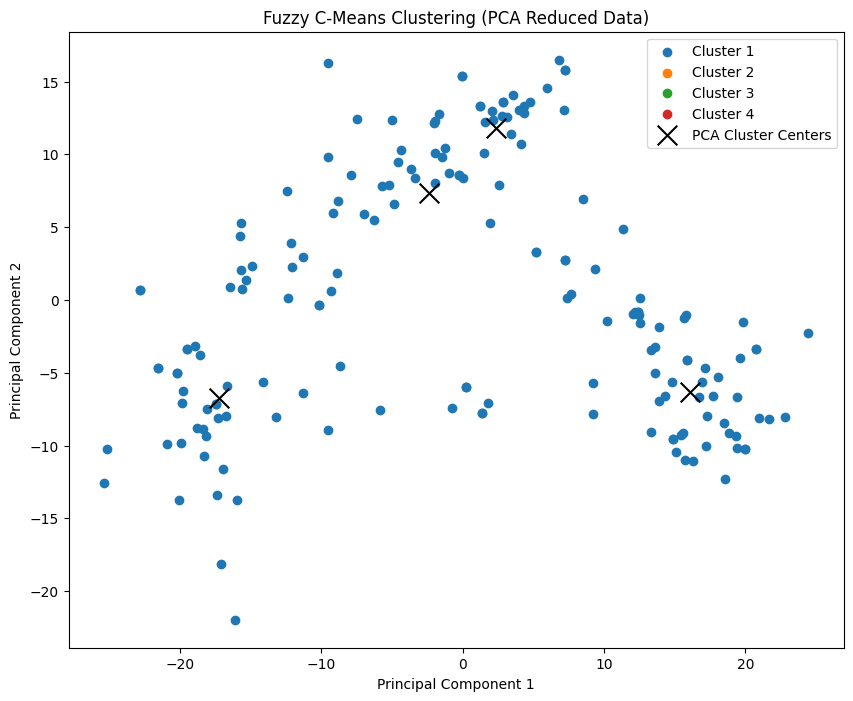

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.19515939992837275
Davies-Bouldin Score: 1.4877094808372648
Rand Score: 0.6154466116529133
Tested fpc: 0.366080918756922
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  6
Liczba klastrów:  4


Processing:  32%|█████████████████████████████████████████████████████▊                                                                                                                   | 7/22 [00:00<?, ?it/s]


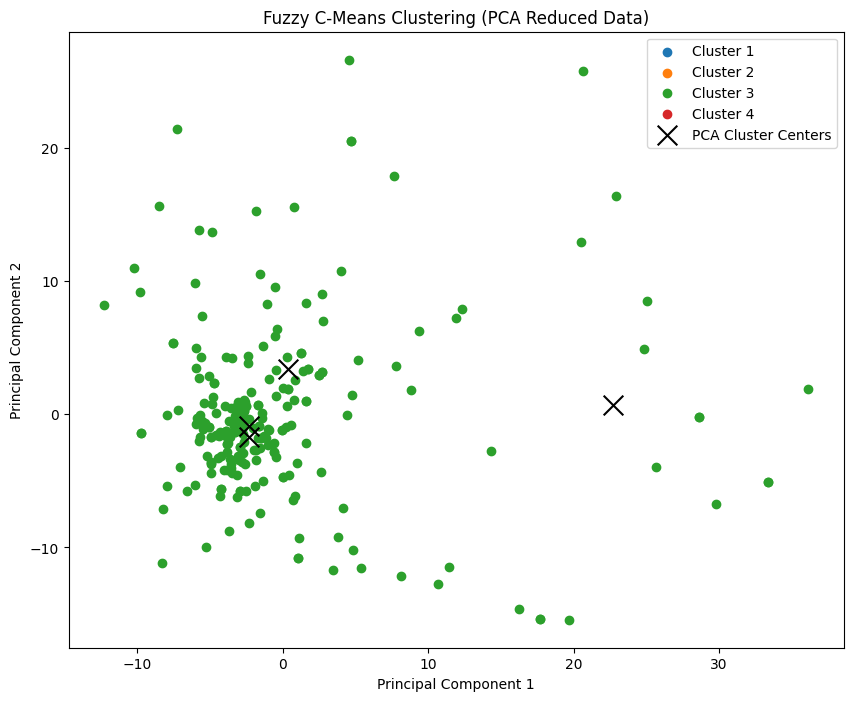

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.2277095061742886
Davies-Bouldin Score: 1.3445944500085718
Rand Score: 0.6490298824706177
Tested fpc: 0.37479615863651344
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  7
Liczba klastrów:  4


Processing:  36%|█████████████████████████████████████████████████████████████▍                                                                                                           | 8/22 [00:00<?, ?it/s]


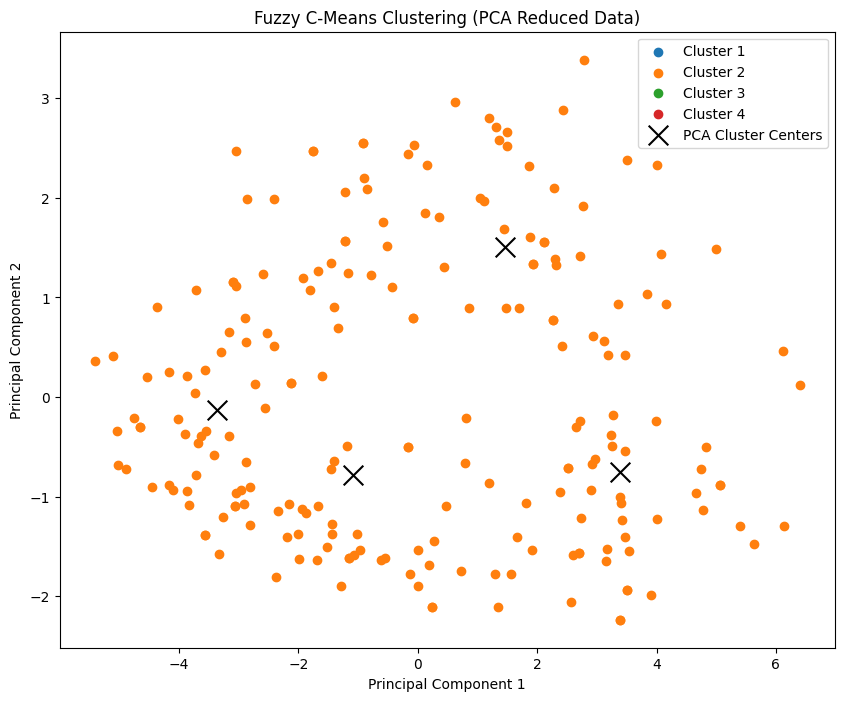

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.11427426408510823
Davies-Bouldin Score: 1.8175201175492401
Rand Score: 0.6784112278069517
Tested fpc: 0.35628577062915323
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  8
Liczba klastrów:  4


Processing:  41%|█████████████████████████████████████████████████████████████████████▏                                                                                                   | 9/22 [00:00<?, ?it/s]


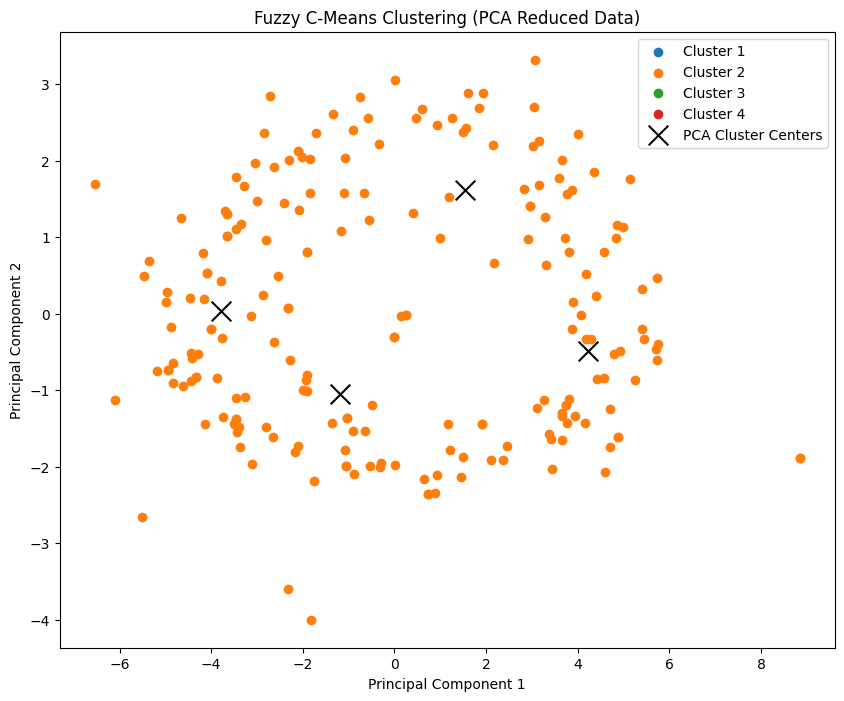

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.11735105505724606
Davies-Bouldin Score: 1.8439335718134526
Rand Score: 0.675162415603901
Tested fpc: 0.3523184953870276
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  9
Liczba klastrów:  4


Processing:  45%|████████████████████████████████████████████████████████████████████████████▎                                                                                           | 10/22 [00:00<?, ?it/s]


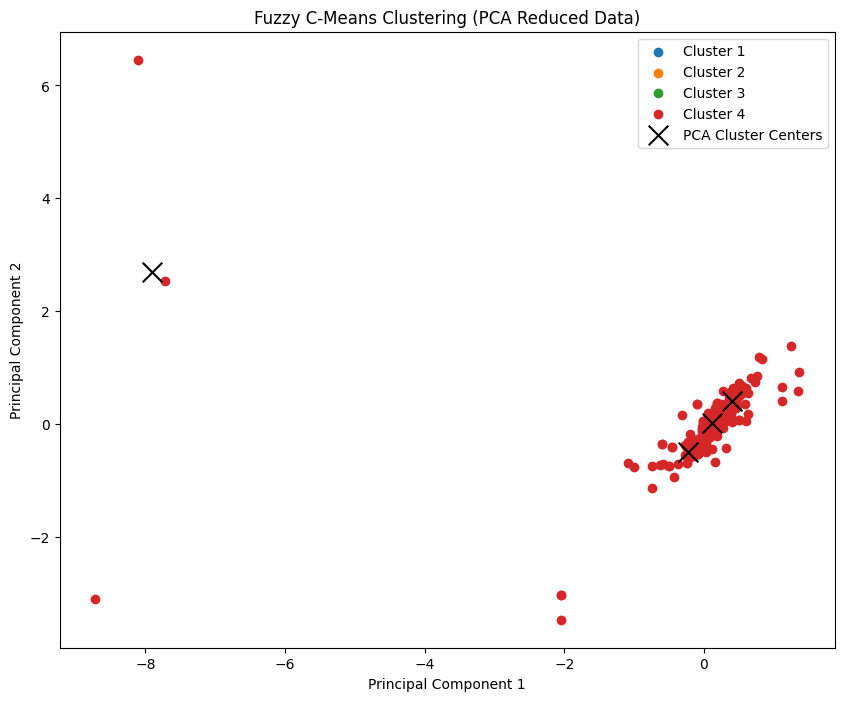

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: -0.09631714934362509
Davies-Bouldin Score: 1.7572801907876034
Rand Score: 0.6435180045011253
Tested fpc: 0.34111738490024673
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  10
Liczba klastrów:  4


Processing:  50%|████████████████████████████████████████████████████████████████████████████████████                                                                                    | 11/22 [00:00<?, ?it/s]


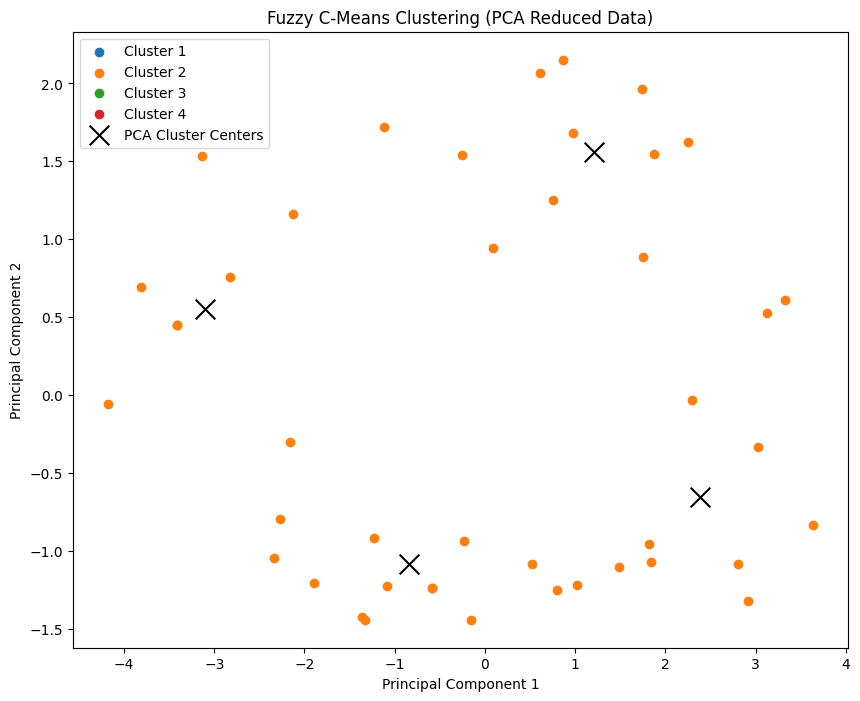

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.09920448129391099
Davies-Bouldin Score: 1.8281704197739792
Rand Score: 0.6674869967491873
Tested fpc: 0.3314319276329297
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  11
Liczba klastrów:  4


Processing:  55%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 12/22 [00:00<?, ?it/s]


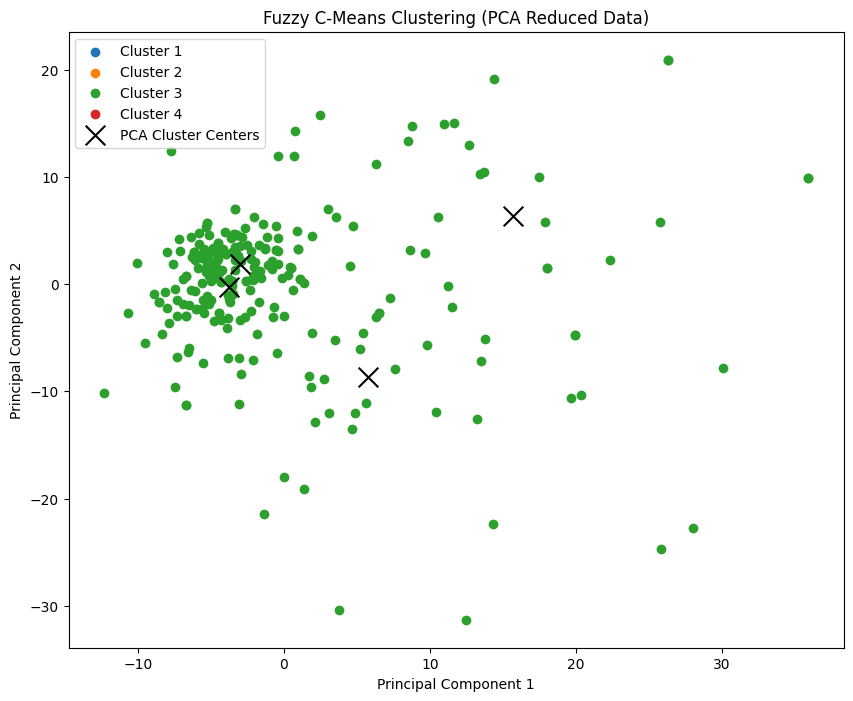

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.26399507265824423
Davies-Bouldin Score: 1.258750337830923
Rand Score: 0.6382511877969492
Tested fpc: 0.43398946343603145
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  12
Liczba klastrów:  4


Processing:  59%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 13/22 [00:00<?, ?it/s]


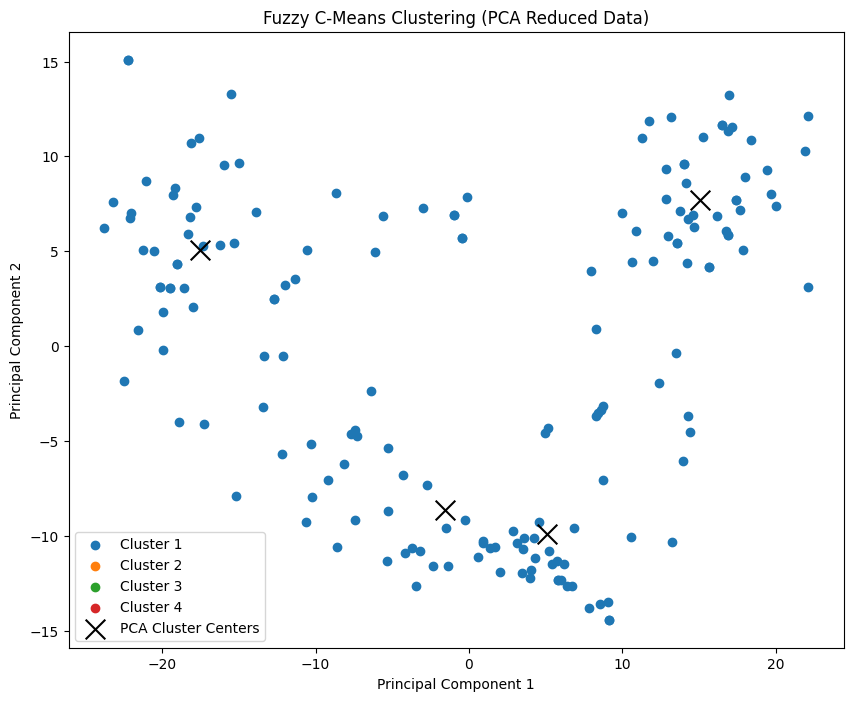

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.16229686712966002
Davies-Bouldin Score: 1.5558053591471457
Rand Score: 0.6211887971992999
Tested fpc: 0.36529046614028754
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  13
Liczba klastrów:  4


Processing:  64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 14/22 [00:00<?, ?it/s]


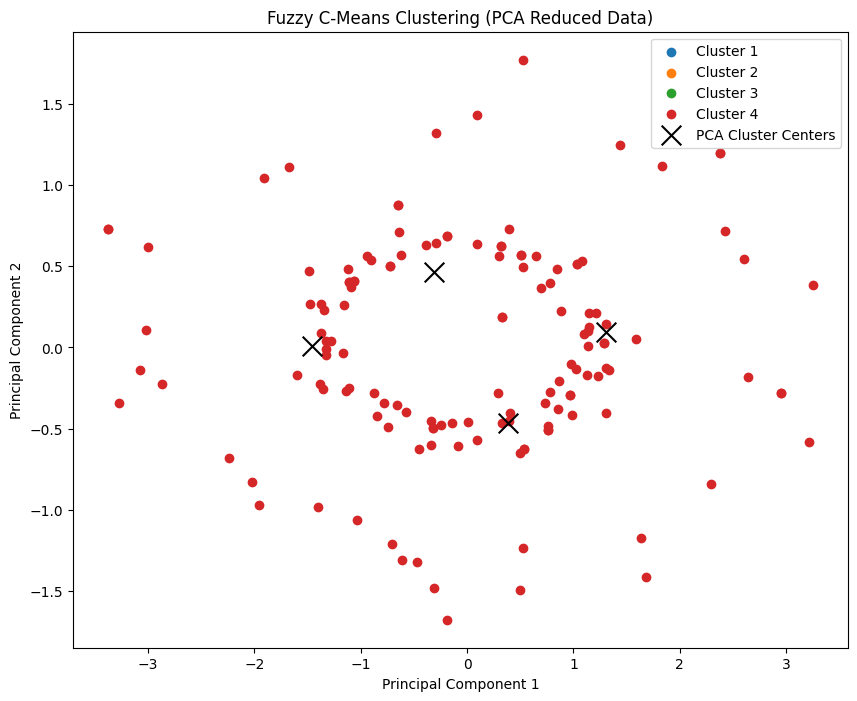

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: -0.1032947968191072
Davies-Bouldin Score: 2.2268678213571027
Rand Score: 0.6420636409102276
Tested fpc: 0.314208192700288
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  14
Liczba klastrów:  4


Processing:  68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 15/22 [00:00<?, ?it/s]


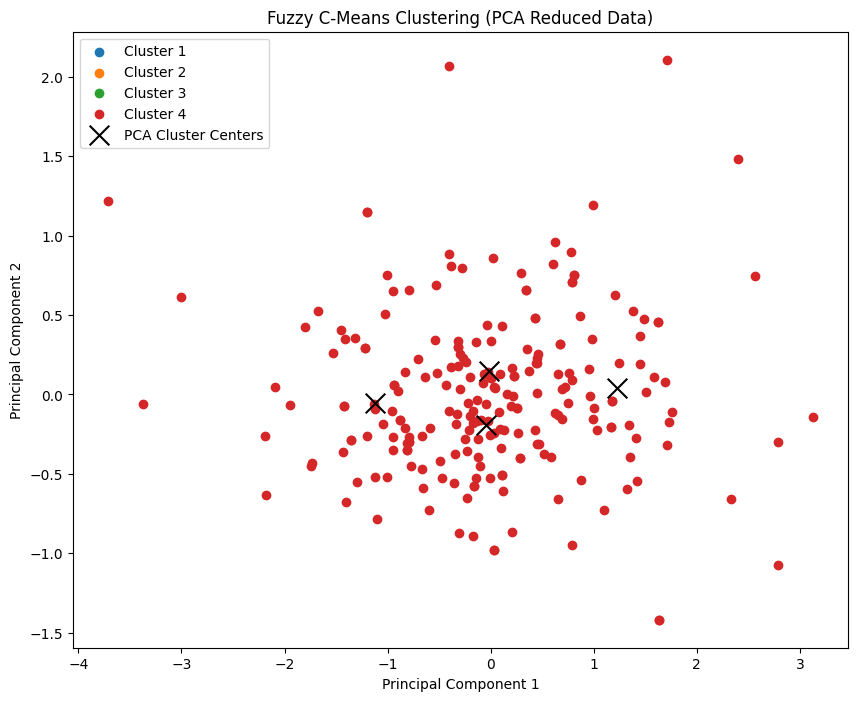

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: -0.16674071868590404
Davies-Bouldin Score: 2.0841900542269887
Rand Score: 0.6284597399349837
Tested fpc: 0.3073468398170287
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  15
Liczba klastrów:  4


Processing:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 16/22 [00:00<?, ?it/s]


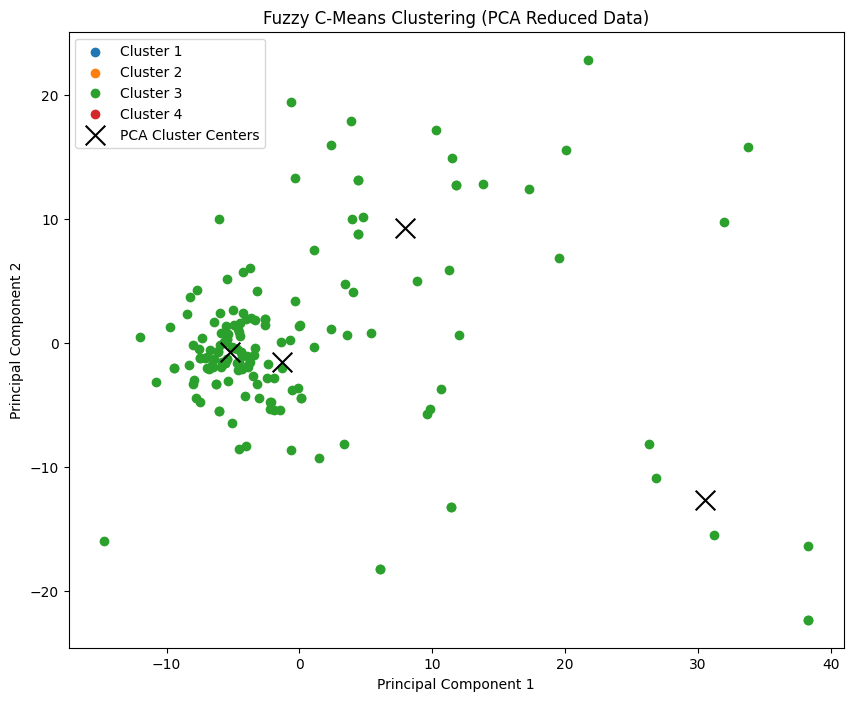

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.4198883798010419
Davies-Bouldin Score: 1.296384361738172
Rand Score: 0.5526076519129782
Tested fpc: 0.5787316094496039
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  16
Liczba klastrów:  4


Processing:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 17/22 [00:00<?, ?it/s]


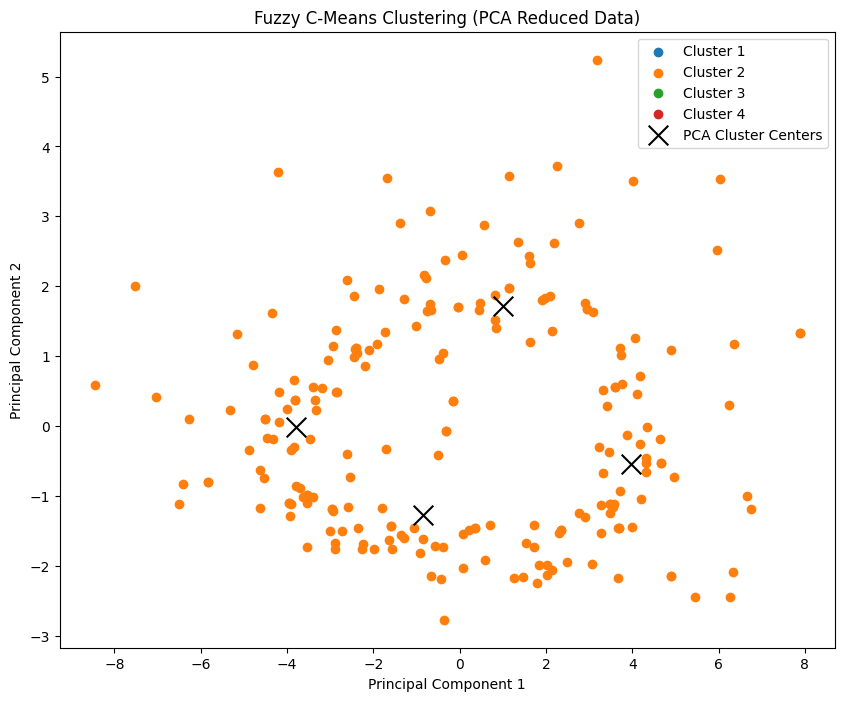

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.06536761709490813
Davies-Bouldin Score: 2.15062168778271
Rand Score: 0.6603464616154039
Tested fpc: 0.3448264840063031
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  17
Liczba klastrów:  4


Processing:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 18/22 [00:00<?, ?it/s]


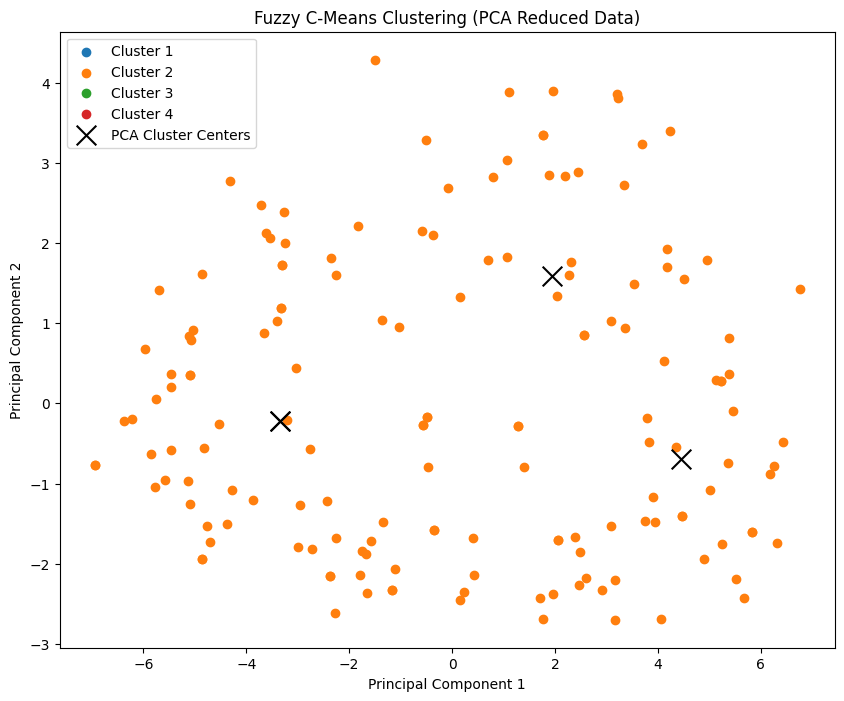

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.11713826401893661
Davies-Bouldin Score: 2.1344547073377673
Rand Score: 0.5387880720180045
Tested fpc: 0.32088320489511696
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  18
Liczba klastrów:  4


Processing:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 19/22 [00:00<?, ?it/s]


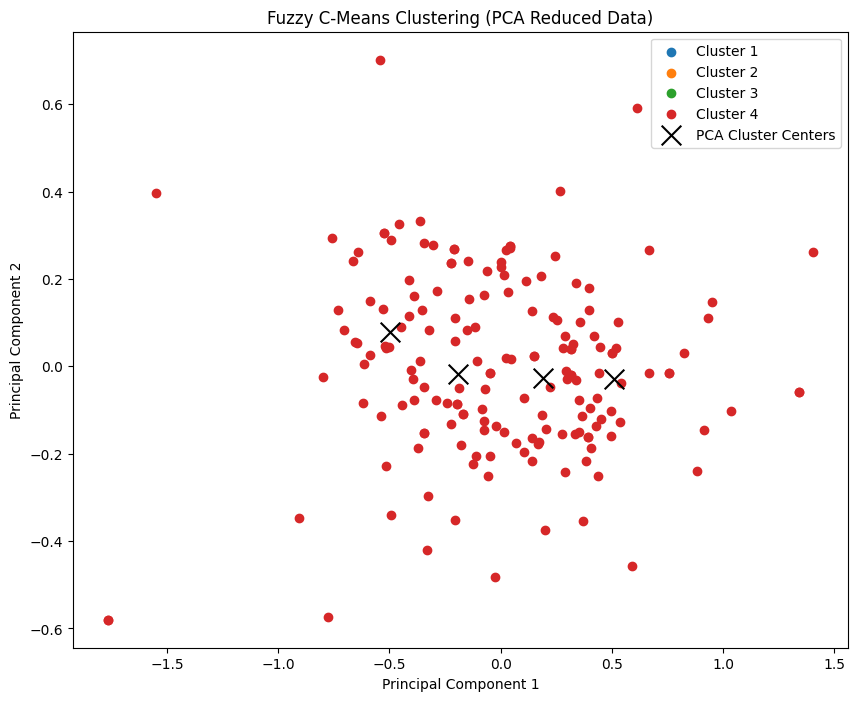

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: -0.2536571643678377
Davies-Bouldin Score: 2.417213872193087
Rand Score: 0.5890736434108527
Tested fpc: 0.28363114007862567
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  19
Liczba klastrów:  4


Processing:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 20/22 [00:00<?, ?it/s]


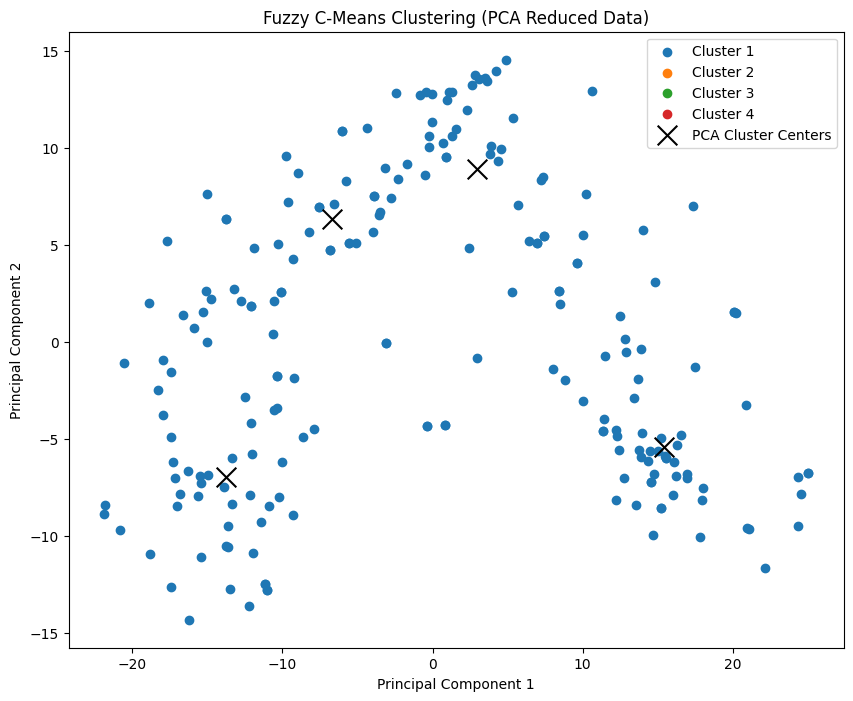

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.22306696180512917
Davies-Bouldin Score: 1.6134746600720586
Rand Score: 0.639680545136284
Tested fpc: 0.3594709004280196
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  20
Liczba klastrów:  4


Processing:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 21/22 [00:00<?, ?it/s]


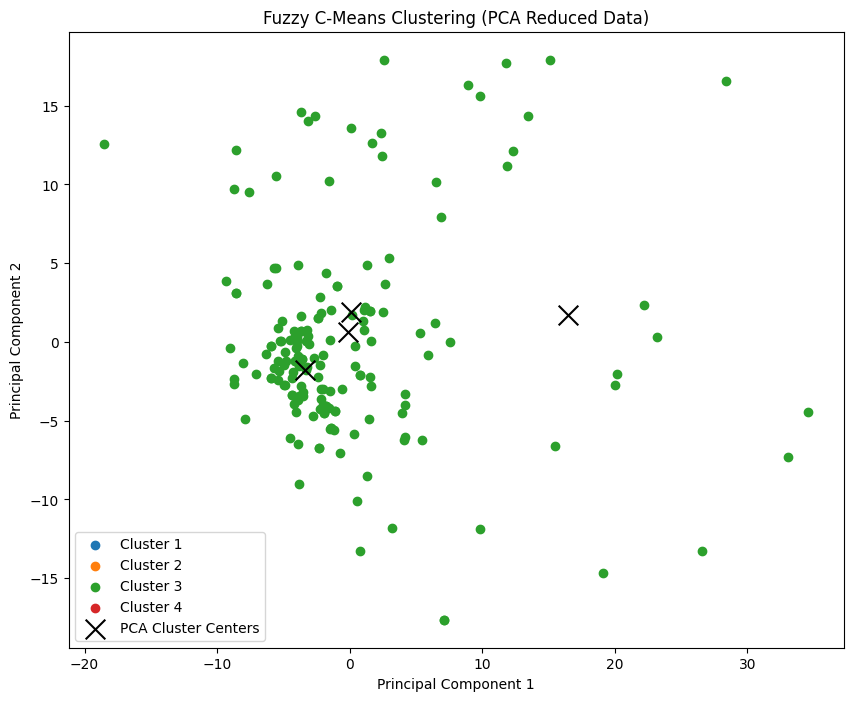

C:\Users\kubak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Silhouette Score: 0.3186740841128601
Davies-Bouldin Score: 1.5599440093458137
Rand Score: 0.5372105526381595
Tested fpc: 0.45176232068373495
Accuracy: 0.325
Precision:  0.2225806451612903
Recall:  0.325
Rozważamy obecnie chunk numer:  21
Liczba klastrów:  4


Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<?, ?it/s]


In [51]:
diagnosis_chunk, diagnosis_iterations = train_incremental_semi_supervised_fuzzy_cmeans(n_clusters, chunks, chunks_y_matrix, chunks_test, chunks_test_y, visualise_data=True)

Historia danych ze względu na kolejne chunki


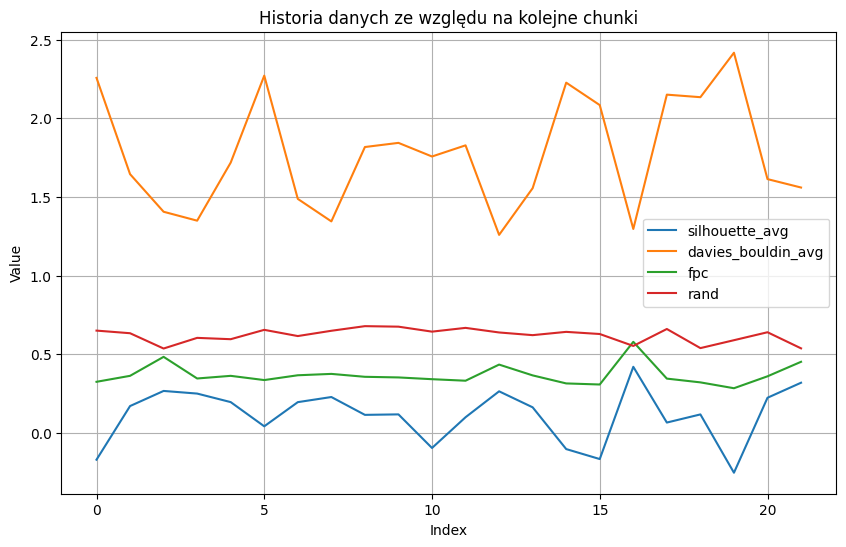

Historia danych wewnatrz iteracji dla pierwszego chunka


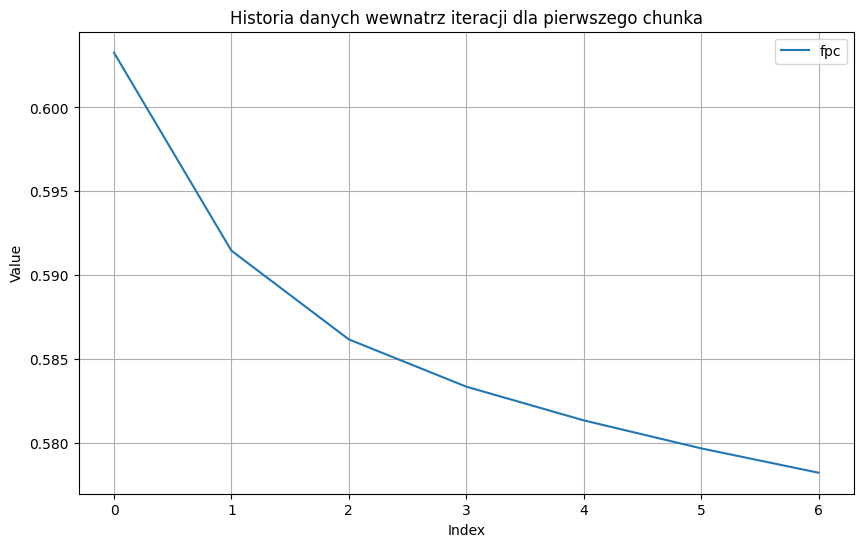

Historia danych ze względu na kolejne chunki + historia rozwoju wewnątrz oblczeń dla pojedyńczego chunku


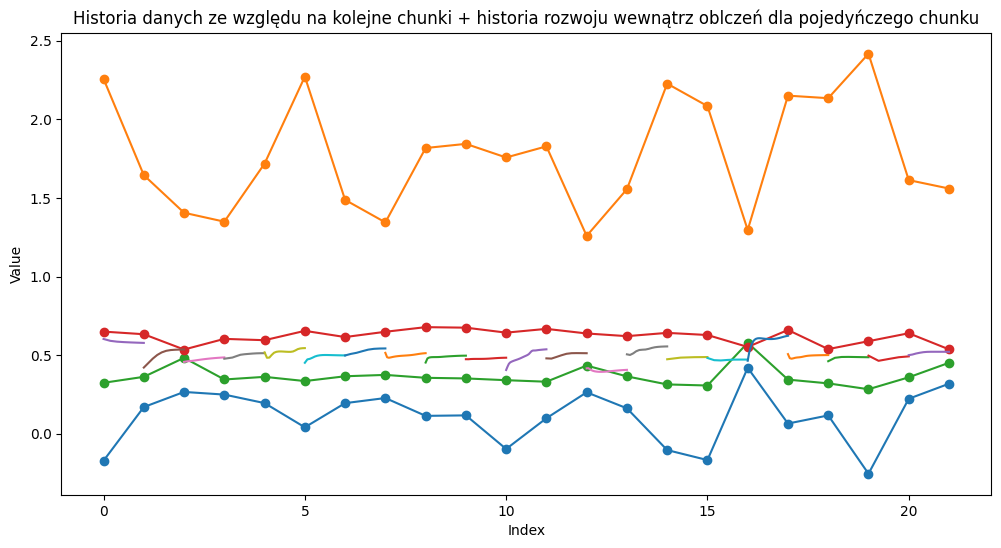

Historia fpc dla wszystkich chunków, i rozwojem wewnatrz chunku


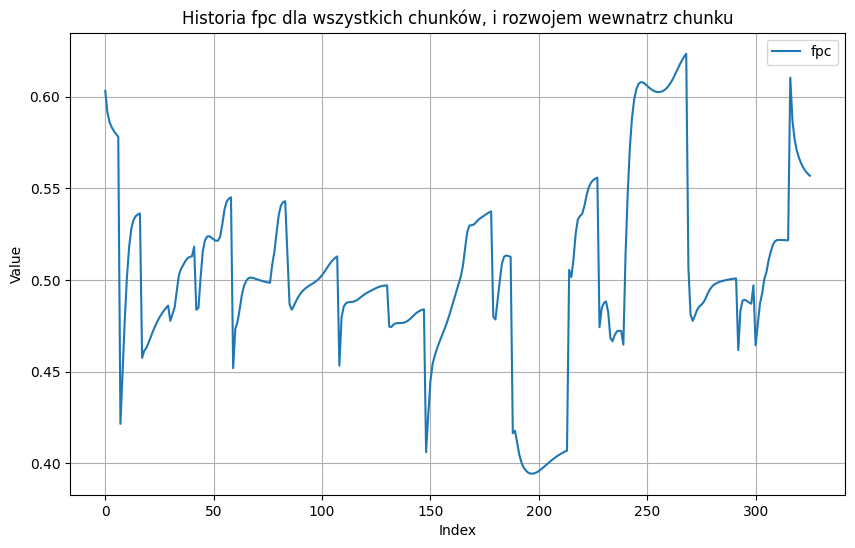

chunk_length_train 200
chunk_length_test 100
n_clusters 4
m 2.0


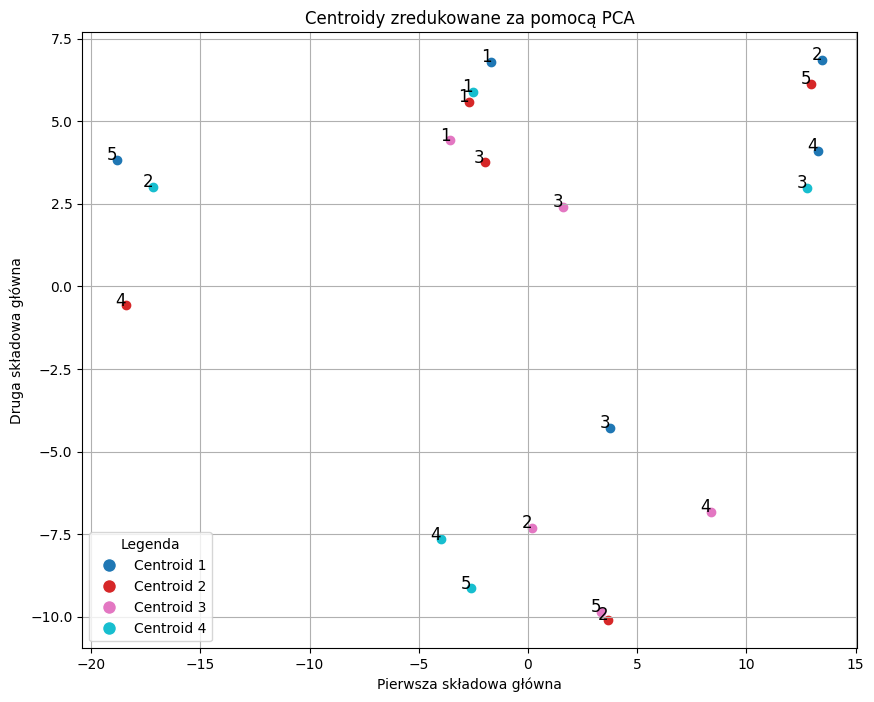

fpc last 0.45176232068373495
rand last 0.5372105526381595


In [52]:
overview_plot(diagnosis_chunk, diagnosis_iterations)

In [53]:
output_data_chunk = []
output_data_iter = []
for n in range(n_clusters, 16):
    print('Rozważam: ', n)
    y_train_matrix, init_centroids = create_semi_supervised_matrix(X_train, y_train, n)
    _, _, chunks_y_matrix = create_chunks(chunk_train_sizes, X_train, y_train, y_train_matrix)
    diagnosis_tools, diagnosis_iterations = train_incremental_semi_supervised_fuzzy_cmeans(n, chunks, chunks_y_matrix, chunks_test, chunks_test_y)
    output_data_chunk.append(diagnosis_tools)
    output_data_iter.append(diagnosis_iterations)

plot_statistic = DiagnosisTools()

Rozważamy obecnie chunk numer:  21
Liczba klastrów:  15


Processing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<?, ?it/s]


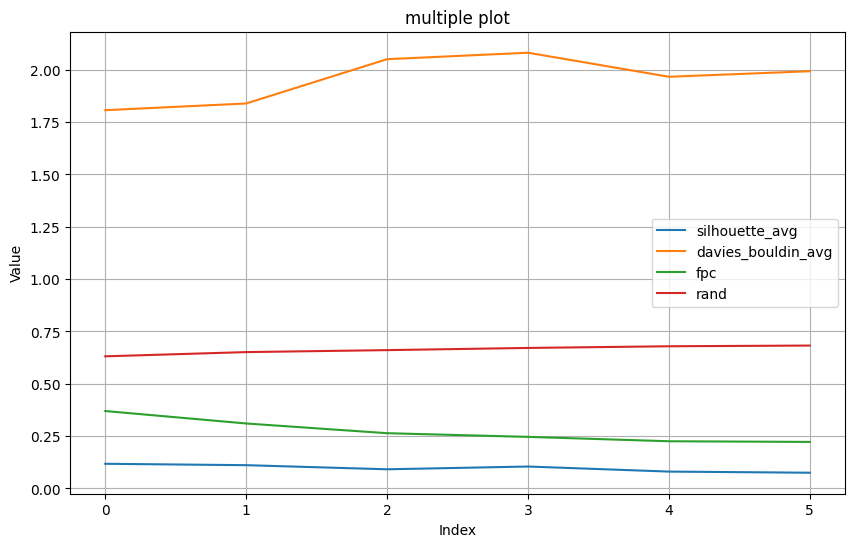

In [54]:
for n in range(n_clusters,10):
    sil, dave, fpc, rand = output_data_chunk[n-n_clusters].get_avg()
    plot_statistic.add_elements(sil, dave, fpc, rand)
plot_statistic.plot_lists()